# Desafío 2

En este desafío se logrará encontrar una relación explicativa entre variables y el precio por m2 de una propiedad en la Ciudad Autónoma de Buenos Aires, a partir del dataset de properati trabajado en el desafío 1, mediante una regresión lineal múltiple (analizar si es necesario combinar con procesador polinómico, y si es mejor con o sin intercepto).

Para esto se seguirán los siguientes pasos:
    1. Limpieza final del dataset
    2. Visualización: Mapa de correlaciones
    3. Preselección de variables para el modelo
    4. Creación de dummies para variables categóricas ****************Exportamos dataset para división********************* 
    5. Obtención de matriz de features (X) y vector de variable explicada (y)
    6. División de dataset en train-test para validación de modelo con randomstate(9) y test size (0.2)
    7. Normalización de set de entrenamiento por estandarización
    8. Prueba de distintos modelos (con el set de train) y evaluación de la performance con el set de test (MAE, MSE, RMSE, R2)
        a. Sin dummies de localización (con lat-lon)
           I)   Sin regularización, con procesador polinómico y uso de stats model
           II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)
        b. Con dummies de localización (sin lat-lon)
           I)   Sin regularización, descartando variables con Stats model
           II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)
           IV)   Sin regularización pero con PCA previo
    9. Selección del mejor modelo
    10. Análisis de los resultados   
    


In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
import unidecode
import re ; import time

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import geopandas as gpd                   ;   from shapely.geometry import Polygon, Point, LineString, LinearRing, MultiPolygon
import shapely as sp                      ;   import matplotlib.pyplot as plt
import seaborn as sns                     ;   import shapely.wkt
from shapely.ops import cascaded_union    ;   from IPython.display import display
import plotly.graph_objects as go

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
startAll = time.time()
def t():
    global start
    start = time.time()
def tt():
    end = time.time() ; minutos = int(round(end - start)/60) ; segundos = int(round(end - start)-(int(round(end - start)/60))*60) ;     tiempo = 'Esta celda tardo en ejecutar: '+str(minutos)+' minutos, '+str(segundos)+' segundos.' ;
    return tiempo
def tiempo():
    endAll = time.time() ; minutos = int(round(endAll - startAll)/60) ; segundos = int(round(endAll - startAll)-(int(round(endAll - startAll)/60))*60) ;     tiempo = 'Desde el inicio, tardo en ejecutar: '+str(minutos)+' minutos, '+str(segundos)+' segundos.' ;
    return tiempo

## 1. Limpieza final del dataset

In [4]:
df = pd.read_csv('df_limpio.csv', sep = '|')

In [5]:
df.shape

(121220, 14)

In [6]:
df.columns

Index(['Unnamed: 0', 'id', 'tipo_propiedad', 'prop_subtipo', 'localidad',
       'provincia', 'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes',
       'expensas', 'descripcion', 'titulo', 'geometry'],
      dtype='object')

In [7]:
df.head(2)

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
0,0,15bo8,PH,PH,Mataderos,Ciudad Autónoma de Buenos Aires,62000.0,55.0000,1127.272727,2.0,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,POINT (-58.5088387 -34.6618237)
1,1,15bob,apartment,apartment,La Plata,Buenos Aires,150000.0,70.4456,2129.302602,2.0,NaN,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,POINT (-57.96432950000001 -34.9038831)


Vemos las pertenecientes a CABA:

In [8]:
df[df['provincia'] == 'Ciudad Autónoma de Buenos Aires'].shape

(32316, 14)

Nos quedamos con las filas pertenecientes a CABA:

In [9]:
df = df[df['provincia'] == 'Ciudad Autónoma de Buenos Aires']

Vemos datos vacíos para las filas de interés:

In [10]:
df.isnull().sum()

Unnamed: 0            0
id                    0
tipo_propiedad        0
prop_subtipo          0
localidad             0
provincia             0
precio_usd            0
superficie_m2         1
usd_m2                1
ambientes          7325
expensas          25724
descripcion           0
titulo                0
geometry              0
dtype: int64

In [11]:
df.tipo_propiedad.unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [12]:
df[df['tipo_propiedad'] == 'house'].isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes          481
expensas          2075
descripcion          0
titulo               0
geometry             0
dtype: int64

In [13]:
df[df['tipo_propiedad'] == 'stores'].isnull().sum()

Unnamed: 0        0
id                0
tipo_propiedad    0
prop_subtipo      0
localidad         0
provincia         0
precio_usd        0
superficie_m2     0
usd_m2            0
ambientes         0
expensas          0
descripcion       0
titulo            0
geometry          0
dtype: int64

LLevamos todos los valores de expersas para casas y a stores a 0, tanto nulos como otros, para corregirlos

In [14]:
df.loc[df['tipo_propiedad'] == (('house') or ('stores')), 'expensas'] = 0

In [15]:
df[df['tipo_propiedad'] == 'house'].isnull().sum()

Unnamed: 0          0
id                  0
tipo_propiedad      0
prop_subtipo        0
localidad           0
provincia           0
precio_usd          0
superficie_m2       1
usd_m2              1
ambientes         481
expensas            0
descripcion         0
titulo              0
geometry            0
dtype: int64

Llenamos las expensas de las propiedades faltantes agrupando por propiedad y barrio

In [16]:
df.expensas.fillna(df.groupby(['tipo_propiedad', 'localidad'])['expensas'].transform('mean'), inplace=True)

In [17]:
df.isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes         7325
expensas           372
descripcion          0
titulo               0
geometry             0
dtype: int64

Llenamos las faltantes con la media por barrio unicamente:

In [18]:
df.expensas.fillna(df.groupby('localidad')['expensas'].transform('mean'), inplace=True)

In [19]:
df.isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes         7325
expensas             4
descripcion          0
titulo               0
geometry             0
dtype: int64

In [20]:
df[df.expensas.isnull()]

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
2763,2763,15ki9,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,95000.0,48.0,1979.166667,1.0,NaN,"Edificio racionalista, Excelente departamento ...",U$D 95.000 - Departamento en Venta - Reconquis...,POINT (-58.38155746 -34.60368347)
5495,5495,15qkd,apartment,apartment_big,Catalinas,Ciudad Autónoma de Buenos Aires,550000.0,300.0,1833.333333,5.0,NaN,Amplia planta en excelente estado conservando ...,Excelente departamento antiguo en venta recicl...,POINT (-58.376624255 -34.6000039032)
63654,63654,1a96l,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,322500.0,44.0,7329.545455,2.0,NaN,EXCELENTE DOS AMBIENTES MUY LUMINOSO ORIENTACI...,LINDO 2 AMB. TODO A NUEVO. APTO. PROFESIONAL,POINT (-58.3728676 -34.5976219)
73605,73605,1anwu,store,store,Catalinas,Ciudad Autónoma de Buenos Aires,350000.0,115.0,3043.478261,NaN,NaN,"""VENTA"" O ""ALQUILER"". PARA VER FOTOS Y PLANO ...",Excelente Local situado en plena zona turística.,POINT (-58.376913 -34.600861)


In [21]:
df[df.localidad == 'Catalinas']

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
2763,2763,15ki9,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,95000.0,48.0,1979.166667,1.0,NaN,"Edificio racionalista, Excelente departamento ...",U$D 95.000 - Departamento en Venta - Reconquis...,POINT (-58.38155746 -34.60368347)
5495,5495,15qkd,apartment,apartment_big,Catalinas,Ciudad Autónoma de Buenos Aires,550000.0,300.0,1833.333333,5.0,NaN,Amplia planta en excelente estado conservando ...,Excelente departamento antiguo en venta recicl...,POINT (-58.376624255 -34.6000039032)
63654,63654,1a96l,apartment,apartment,Catalinas,Ciudad Autónoma de Buenos Aires,322500.0,44.0,7329.545455,2.0,NaN,EXCELENTE DOS AMBIENTES MUY LUMINOSO ORIENTACI...,LINDO 2 AMB. TODO A NUEVO. APTO. PROFESIONAL,POINT (-58.3728676 -34.5976219)
73605,73605,1anwu,store,store,Catalinas,Ciudad Autónoma de Buenos Aires,350000.0,115.0,3043.478261,NaN,NaN,"""VENTA"" O ""ALQUILER"". PARA VER FOTOS Y PLANO ...",Excelente Local situado en plena zona turística.,POINT (-58.376913 -34.600861)


Como no hay otras propiedades en Catalinas para usar de parámetro, llenamos por tipo de propiedad en general:

In [22]:
df.expensas.fillna(df.groupby('tipo_propiedad')['expensas'].transform('mean'), inplace=True)

In [23]:
df.isnull().sum()

Unnamed: 0           0
id                   0
tipo_propiedad       0
prop_subtipo         0
localidad            0
provincia            0
precio_usd           0
superficie_m2        1
usd_m2               1
ambientes         7325
expensas             0
descripcion          0
titulo               0
geometry             0
dtype: int64

Para las faltantes de ambientes, vemos la distribución:

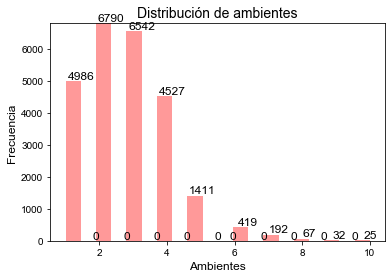

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.distplot(df['ambientes'],kde=False, color='Red', bins=20)
plt.title('Distribución de ambientes', fontsize=14)
plt.xlabel('Ambientes', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

import math
# Set plotting style
sns.set_style('whitegrid')

# Get current axis on current figure
ax = plt.gca()

# ylim max value to be set
y_max = df['ambientes'].value_counts().max() 
ax.set_ylim([0, y_max])

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()


In [25]:
df[df.ambientes > 6].shape

(316, 14)

### Decisión: nuestro modelo explicará la variación del precio por m2 de propiedades de hasta 6 ambientes en la Ciudad de Buenos Aires

Tiramos los valores que no nos son útiles.

In [26]:
df = df[~(df.ambientes > 6)]

In [27]:
df.shape

(32000, 14)

Ahora podemos rellenar el dataset con los ambientes por media, teniendo en cuenta el subtipo de propiedad. 
Más adelante se analizará si suma o resta al modelo involucrar la variable ambientes, ya que muchos de sus datos serán estimados por la media.

In [28]:
df.ambientes.fillna(df.groupby(['prop_subtipo'])['ambientes'].transform('mean'), inplace=True)

In [29]:
df.isnull().sum()

Unnamed: 0        0
id                0
tipo_propiedad    0
prop_subtipo      0
localidad         0
provincia         0
precio_usd        0
superficie_m2     1
usd_m2            1
ambientes         0
expensas          0
descripcion       0
titulo            0
geometry          0
dtype: int64

Quedó un dato vacío en Y, vemos cuál es y lo eliminamos.

In [30]:
df[df.usd_m2.isna()]

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry
24895,24895,17p8s,house,house,Congreso,Ciudad Autónoma de Buenos Aires,63000.0,NaN,NaN,1.0,0.0,"1 AMB DIVISIBLE, SE VENDE TODO EQUIPADO, BAO C...",1004,POINT (-58.391032 -34.610544)


In [31]:
df.dropna(inplace=True)

## Agregamos variables categóricas 'cochera' y 'amenities'

### regEX en busca de amenities
nos tramos las funciones de nuestra limpieza para buscar palabras clave

In [32]:
# acomodamos algunas palabras para simplificar la busqueda
df.descripcion = df.descripcion.str.replace('jacuzi','jacuzzi')
df.descripcion = df.descripcion.str.replace('picina','pileta')
df.descripcion = df.descripcion.str.replace('piscina','pileta')
df.descripcion = df.descripcion.str.replace('garage','cochera')
df.descripcion = df.descripcion.str.replace('salon de usos multiples','S.U.M.')

In [33]:
# quitamos acentos
def normalize_text(data):
    data = unidecode.unidecode(data)
    data = data.lower()
    return data

df.descripcion = df.descripcion.map(normalize_text)

In [34]:
# eliminamos el "No es apto crédito" para poder buscar "Apto crédito" sin errores
df.descripcion = df.descripcion.str.replace('no es apto credito','')

In [35]:
# establecemos una lista de amenities que nos interesa buscar
lista_am = ['cochera','pileta','jacuzzi','ping pong','parilla','s.u.m.','apto credito','apto profesional',
            'solarium','terraza propia']

In [36]:
# reestsablecemos el index
df.reset_index(inplace=True,drop=True)

In [37]:
# generamos una copia de nuestro df solo con el id
amenities = df[['id']].copy()

for i in range(len(lista_am)):
    pattern = '('+lista_am[i]+')' # establecemos el pattern dinamicamente
    regex = re.compile(pattern, flags = re.IGNORECASE)
    
    temp = df.descripcion.str.extract(pattern)     # esto nos devuelve una serie con los resultados
    temp.columns = [lista_am[i]]                   # renombramos su columna con la ammenitie buscada
    amenities = pd.concat([amenities,temp],axis=1) # concatenamos al df vacio que nos generamos 
    print(pattern)

(cochera)
(pileta)
(jacuzzi)
(ping pong)
(parilla)
(s.u.m.)
(apto credito)
(apto profesional)
(solarium)
(terraza propia)


In [38]:
# visualizamos lo encontrado
amenities.describe()

,id,cochera,pileta,jacuzzi,ping pong,parilla,s.u.m.,apto credito,apto profesional,solarium,terraza propia
count,31999,11120,5010,1729,25,119,579,2742,3858,6260,738
unique,31999,1,1,1,1,1,10,1,1,1,1
top,1cj0z,cochera,pileta,jacuzzi,ping pong,parilla,s.u.m.,apto credito,apto profesional,solarium,terraza propia
freq,1,11120,5010,1729,25,119,400,2742,3858,6260,738


In [39]:
# generamos unas dummies de forma "casera"
amenities.fillna(0,inplace=True)

for i in range(amenities.shape[1]-1):
    amenities.loc[amenities[lista_am[i]]!=0,lista_am[i]] = 1

In [40]:
# visualizamos las cantidades
datos = amenities[lista_am].describe()

# vemos que 1/3 del dataset tiene cochera, por lo que se decide utilizarla por si sola y con el resto hacer 1 sola columna
datos.loc['count']-datos.loc['freq']

cochera             11120
pileta               5010
jacuzzi              1729
ping pong              25
parilla               119
s.u.m.                579
apto credito         2742
apto profesional     3858
solarium             6260
terraza propia        738
dtype: int64

In [41]:
# renombramos las columnas cambiando " " por "_"
amen = list(amenities.columns)

new_name = []
for i in range(len(amen)):
    new_name.append(amen[i].replace(' ','_'))

amenities.columns = new_name

In [42]:
# estas las agrupamos en una variable
amenities

,id,cochera,pileta,jacuzzi,ping_pong,parilla,s.u.m.,apto_credito,apto_profesional,solarium,terraza_propia
0,15bo8,0,0,0,0,0,0,0,0,0,0
1,15bod,0,0,0,0,0,0,0,0,0,0
2,15boh,0,0,0,0,0,0,0,0,0,0
3,15bot,0,1,0,0,0,0,0,1,1,0
4,15bou,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
31994,1cj5v,0,0,0,0,0,0,0,0,0,0
31995,1cj7c,0,0,0,0,0,0,0,0,0,0
31996,1cja2,1,1,0,0,0,0,0,0,0,0
31997,1cja7,1,0,0,0,0,0,0,0,1,0


In [43]:
# cochera se usa por si sola y con el resto generamos "con_amen"
amenities['con_amen'] = amenities[amenities.columns[1:]].max(axis=1)

In [44]:
np.random.seed(0)
amenities.sample(5)

,id,cochera,pileta,jacuzzi,ping_pong,parilla,s.u.m.,apto_credito,apto_profesional,solarium,terraza_propia,con_amen
31329,1cgx0,1,0,0,0,0,0,0,0,0,0,1.0
3514,16x8r,0,0,0,0,0,0,0,1,0,0,1.0
12363,199r6,0,0,0,0,0,0,0,0,0,0,0.0
25927,1biu7,0,0,0,0,0,0,0,0,0,0,0.0
31885,1ciz9,0,0,0,0,0,0,0,0,0,0,0.0


##### finalmente las agregamos a df

In [45]:
df['amenities'] = amenities.con_amen.astype(int)

In [46]:
df.head(3)

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry,amenities
0,0,15bo8,PH,PH,Mataderos,Ciudad Autónoma de Buenos Aires,62000.0,55.000000,1127.272727,2.0,394.444444,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,POINT (-58.5088387 -34.6618237),0
1,2,15bod,apartment,apartment,Mataderos,Ciudad Autónoma de Buenos Aires,72000.0,55.000000,1309.090909,2.0,1106.250000,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,POINT (-58.5229825 -34.6522615),0
2,3,15boh,PH,PH,Liniers,Ciudad Autónoma de Buenos Aires,95000.0,99.871429,951.223001,3.0,475.166667,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,POINT (-58.5164244 -34.6477969),0


In [47]:
df.shape

(31999, 15)

## Modificamos la variable 'geometry' para que se pueda usar en la predicción

In [48]:
def get_points(data):
    ''' esta funcion toma un punto en STR y lo convierte en geometria'''

    data = data.strip('POINT (')
    data = data.strip(')')

    lon = float(data.split(' ')[0][:9])
    lat = float(data.split(' ')[1][:9])

    return Point(lon,lat)

# df_xl['lat'] = [df.geometry.iloc[i].y for i in range(len(df))]
# df_xl['lon'] = [df.geometry.iloc[i].x for i in range(len(df))]

In [49]:
df.columns

Index(['Unnamed: 0', 'id', 'tipo_propiedad', 'prop_subtipo', 'localidad',
       'provincia', 'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes',
       'expensas', 'descripcion', 'titulo', 'geometry', 'amenities'],
      dtype='object')

In [50]:
df['lat'] = [x.strip('POINT (').strip(')').split(' ')[1] for x in df.geometry]
df['lon'] = [x.strip('POINT (').strip(')').split(' ')[0] for x in df.geometry]

In [51]:
df.geometry.iloc[0].strip('POINT (').strip(')').split(' ')

['-58.5088387', '-34.6618237']

In [52]:
df.head(3)

,Unnamed: 0,id,tipo_propiedad,prop_subtipo,localidad,provincia,precio_usd,superficie_m2,usd_m2,ambientes,expensas,descripcion,titulo,geometry,amenities,lat,lon
0,0,15bo8,PH,PH,Mataderos,Ciudad Autónoma de Buenos Aires,62000.0,55.000000,1127.272727,2.0,394.444444,"2 ambientes tipo casa planta baja por pasillo,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,POINT (-58.5088387 -34.6618237),0,-34.6618237,-58.5088387
1,2,15bod,apartment,apartment,Mataderos,Ciudad Autónoma de Buenos Aires,72000.0,55.000000,1309.090909,2.0,1106.250000,2 ambientes 3er piso lateral living comedor am...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,POINT (-58.5229825 -34.6522615),0,-34.6522615,-58.5229825
2,3,15boh,PH,PH,Liniers,Ciudad Autónoma de Buenos Aires,95000.0,99.871429,951.223001,3.0,475.166667,ph 3 ambientes con patio. hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,POINT (-58.5164244 -34.6477969),0,-34.6477969,-58.5164244


Finalmente, eliminamos la columna unnamed e id ya que no están relacionadas con el precio y no aportan información al modelo

In [53]:
df = df[['tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia', 'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes',
       'expensas', 'descripcion', 'titulo', 'geometry', 'amenities', 'lat', 'lon']]

In [54]:
df.lat= df.lat.astype(float)
df.lon= df.lon.astype(float)

In [55]:
df_sin_dummies = df[['localidad','lat','lon']].copy()

In [56]:
df_sin_dummies.lat.mean()

-34.60110959983453

## 2. Visualización: Mapa de correlaciones

Con el dataset listo, realizamos un mapa de correlaciones para visualizar la importancia de cada variable para el modelo a construir:

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

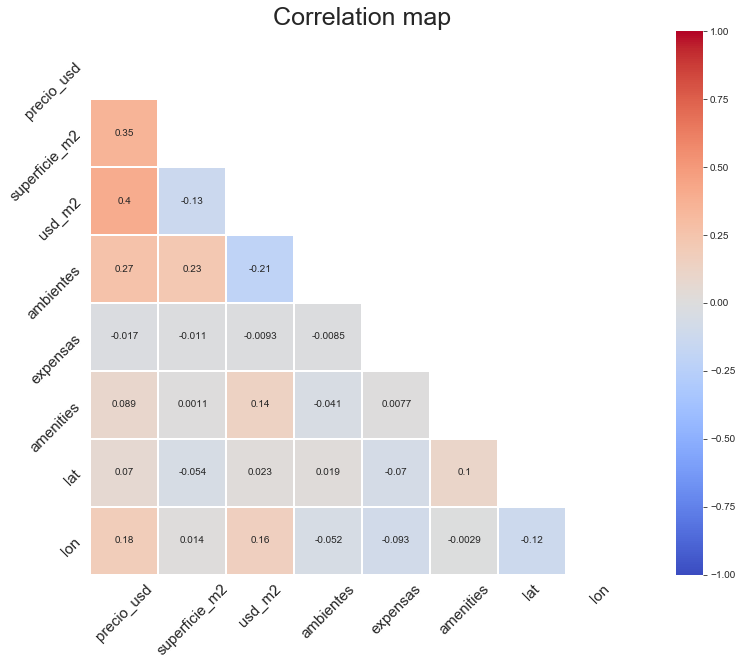

In [57]:
corr = df.corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(15,10))
ax = sns.heatmap(
    corr, annot=True, 
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=1, mask=mask, cmap = 'coolwarm'
)


plt.title('Correlation map', size = 25)
plt.xticks(size =15, rotation=45)
plt.yticks(size =15,rotation=45)


## 3. Preselección de variables para el modelo

Vemos la poca correlación que tiene expesnas, por lo que es en principio poco útil para el modelo, por lo que, sumado a que no era una variable que viniese muy completa, se la dejará de lado para la creación del modelo.

Notamos además una altísima correlación entre el precio de la propiedad y el precio por m2, lo que es esperado ya que la primera revela información de la segunda. Por esto tampoco se la incluirá en el modelo.

Las variables restantes parecen ser de gran importancia.


## 4. Creación de dummies para variables categóricas

Usaremos el subtipo de propiedad generado y la localidad.

en prop_subtipo, tenemos tipo_size... vamos a hacer de ello 2 columnas para que las dummies sean menos y mas consistentes, quitaremos pa parte de tipo_ en prop_subtipo ya que es lo mismo que tipo de propiedad, y en prop subtipo quedará solo el tamaño. y con esto haremos las dummies

In [58]:
df.prop_subtipo.unique()

array(['PH', 'apartment', 'house', 'store', 'apartment_big', 'house_big',
       'PH_big', 'store_xl', 'apartment_xl', 'store_big', 'house_xl',
       'PH_xl'], dtype=object)

In [59]:
df.loc[(df.prop_subtipo == 'PH')|
       (df.prop_subtipo == 'apartment')|
       (df.prop_subtipo == 'house')|
       (df.prop_subtipo == 'store'),'prop_subtipo'] = 'normal'

In [60]:
df.loc[(df.prop_subtipo == 'apartment_big')|
       (df.prop_subtipo == 'house_big')|
       (df.prop_subtipo == 'PH_big')|
       (df.prop_subtipo == 'store_big'),'prop_subtipo'] = 'big'

In [61]:
df.loc[(df.prop_subtipo == 'store_xl')|
       (df.prop_subtipo == 'apartment_xl')|
       (df.prop_subtipo == 'house_xl')|
       (df.prop_subtipo == 'PH_xl'),'prop_subtipo'] = 'xl'

In [62]:
df.prop_subtipo.unique()

array(['normal', 'big', 'xl'], dtype=object)

In [63]:
df.tipo_propiedad.unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [64]:
dummies = pd.get_dummies(df[['tipo_propiedad','prop_subtipo', 'localidad']],prefix=['prop','size','loc'], drop_first=True)
# acortamos un poco el prefijo de localidad
dummies.head(2)

,prop_apartment,prop_house,prop_store,size_normal,size_xl,loc_Agronomía,loc_Almagro,loc_Balvanera,loc_Barracas,loc_Barrio Norte,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Mejora
tenemos 5 dummies para propiedad y tamaño, lo que antes eran 11 variables

In [65]:
df = pd.concat([df, dummies], axis='columns')

In [66]:
df.shape

(31999, 81)

In [67]:
df.columns

Index(['tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia',
       'precio_usd', 'superficie_m2', 'usd_m2', 'ambientes', 'expensas',
       'descripcion', 'titulo', 'geometry', 'amenities', 'lat', 'lon',
       'prop_apartment', 'prop_house', 'prop_store', 'size_normal', 'size_xl',
       'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera', 'loc_Barracas',
       'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca', 'loc_Boedo',
       'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas',
       'loc_Centro / Microcentro', 'loc_Chacarita', 'loc_Coghlan',
       'loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores',
       'loc_Floresta', 'loc_Las Cañitas', 'loc_Liniers', 'loc_Mataderos',
       'loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once',
       'loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood',
       'loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
       'loc_Parque Centenario', 'loc_Parque Chacabuco', 'loc_Parque Chas',
     

Reindexamos para que quede como primera columna la variable objetivo: y eliminamos algunas columnas que ya no necesitamos

In [68]:
# las variables que no debemos utilizar para fitear el modelo son las 2 primeras
df = df[['usd_m2', 'precio_usd',
         
         'prop_apartment', 'prop_house', 'prop_store', 'size_normal', 'size_xl',
         'superficie_m2', 'ambientes', 'amenities', 'lat','lon',
         
         #'tipo_propiedad', 'prop_subtipo', 'localidad', 'provincia','expensas','descripcion', 'titulo', 'geometry', 
         
         'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera','loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
         'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas','loc_Centro / Microcentro', 'loc_Chacarita',
         'loc_Coghlan','loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores','loc_Floresta', 'loc_Las Cañitas',
         'loc_Liniers', 'loc_Mataderos','loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once','loc_Palermo',
         'loc_Palermo Chico', 'loc_Palermo Hollywood','loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
         'loc_Parque Centenario', 'loc_Parque Chacabuco', 'loc_Parque Chas','loc_Parque Patricios', 'loc_Paternal',
         'loc_Pompeya','loc_Puerto Madero', 'loc_Recoleta', 'loc_Retiro', 'loc_Saavedra','loc_San Cristobal',
         'loc_San Nicolás', 'loc_San Telmo','loc_Tribunales', 'loc_Velez Sarsfield', 'loc_Versalles','loc_Villa Crespo',
         'loc_Villa Devoto', 'loc_Villa General Mitre','loc_Villa Lugano', 'loc_Villa Luro', 'loc_Villa Ortuzar',
         'loc_Villa Pueyrredón', 'loc_Villa Real', 'loc_Villa Riachuelo','loc_Villa Santa Rita', 'loc_Villa Soldati',
         'loc_Villa Urquiza','loc_Villa del Parque']]

In [69]:
df.head()

,usd_m2,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,1,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,1,0,99.871429,3.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,1,0,0,1,0,45.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,1,0,0,1,0,65.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0


Exportamos el dataframe final, listo para trabajar:

In [70]:
# todo completo
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [71]:
# columnas ordenadas y depuradas
df.head(3)

,usd_m2,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,1,0,55.000000,2.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,1,0,0,1,0,55.000000,2.0,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,1,0,99.871429,3.0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df.to_csv('df_limpio_modelo.csv',sep='|',index=None)

# HASTA ACÁ ESTÁ EN EL ARCHIVO EXPORTADO
Para analizar distitos modelos comenzamos desde aqui con la importación del df_limpio_modelo.csv, y realizando de los puntos 5 al 7 para preparación del dataset.

In [73]:
df = pd.read_csv('df_limpio_modelo.csv',sep='|')

In [74]:
df.head()

,usd_m2,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,1,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,1,0,99.871429,3.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,1,0,0,1,0,45.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,1,0,0,1,0,65.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0


## Sin dummies de localidades
solo con los datos de lat-lon

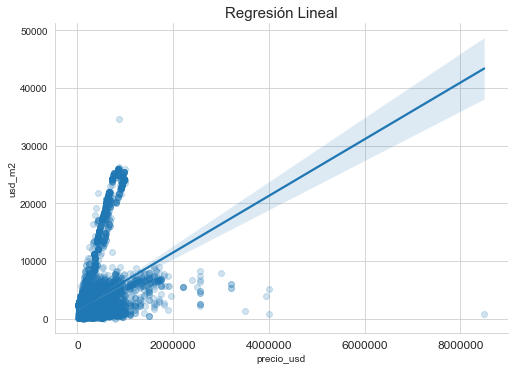

In [75]:
sns.lmplot(x = 'precio_usd', y = 'usd_m2',data=df, aspect=1.45, scatter_kws={'alpha':0.2})
plt.title("Regresión Lineal",size=15)
plt.xticks(size=12)
plt.xticks(size=12);

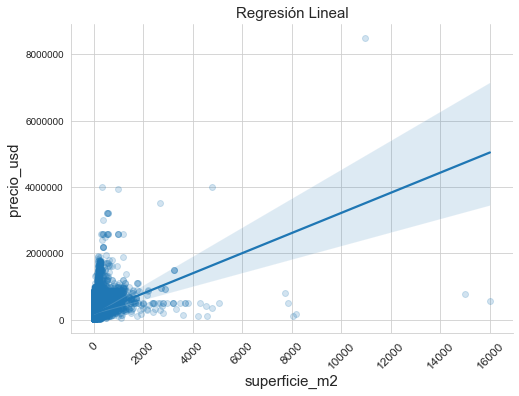

In [76]:
# cuanto mas grande mas caro en total
sns.lmplot(x = 'superficie_m2', y = 'precio_usd',data=df, aspect=1.45, scatter_kws={'alpha':0.2})
plt.title("Regresión Lineal",size=15)
plt.xticks(size=12,rotation=45)
plt.xticks(size=12, rotation=45)
plt.xlabel('superficie_m2',size=15)
plt.ylabel('precio_usd',size=15);

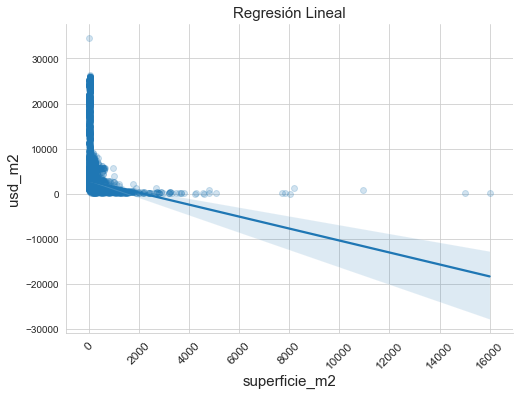

In [77]:
# cuanto mas grande mas barato en general
sns.lmplot(x = 'superficie_m2', y = 'usd_m2',data=df, aspect=1.45, scatter_kws={'alpha':0.2})
plt.title("Regresión Lineal",size=15)
plt.xticks(size=12,rotation=45)
plt.xticks(size=12, rotation=45)
plt.xlabel('superficie_m2',size=15)
plt.ylabel('usd_m2',size=15);

### 5. Obtención de matriz de features (X) y vector de variable explicada (y)

Observamos las columnas de nuestro dataset actual

In [78]:
df.head()

,usd_m2,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,1,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,1,0,99.871429,3.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,1,0,0,1,0,45.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,1,0,0,1,0,65.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

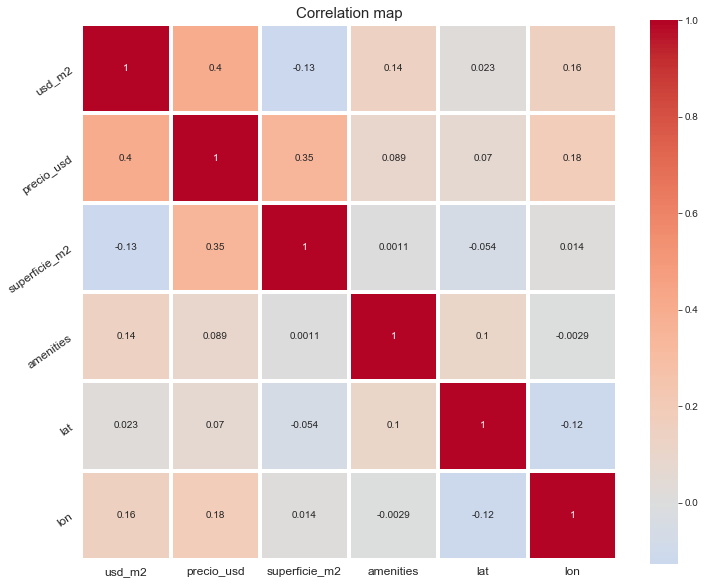

In [79]:
corr = df[['usd_m2','precio_usd','superficie_m2','amenities','lat','lon']].corr()

plt.figure(figsize=(12,10))
ax = sns.heatmap(corr, annot=True, center=0, square=True, linewidths=3, cmap = 'coolwarm')

plt.title('Correlation map', size = 15)
plt.xticks(size =12)
plt.yticks(size =12,rotation=35)

In [80]:
df.columns[:2]

Index(['usd_m2', 'precio_usd'], dtype='object')

In [81]:
df.columns[2:19]

Index(['prop_apartment', 'prop_house', 'prop_store', 'size_normal', 'size_xl',
       'superficie_m2', 'ambientes', 'amenities', 'lat', 'lon',
       'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera', 'loc_Barracas',
       'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca'],
      dtype='object')

La columna usd_m2 representa el precio por metro cuadrado en dólares. Esta va a ser nuestra variable **target**, a la que llamaremos y.

Las columnas de superficie, ambientes y expensas, sumadas a las dummies correspondientes a las variables categóricas de subtipo de propiedad y localidad, son las posibles variables explicativas que nos permitiran llegar al valor de nuestra y. Estas serán nuestras **features** y estarán en la matriz X.


In [82]:
df.columns

Index(['usd_m2', 'precio_usd', 'prop_apartment', 'prop_house', 'prop_store',
       'size_normal', 'size_xl', 'superficie_m2', 'ambientes', 'amenities',
       'lat', 'lon', 'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera',
       'loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
       'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas',
       'loc_Centro / Microcentro', 'loc_Chacarita', 'loc_Coghlan',
       'loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores',
       'loc_Floresta', 'loc_Las Cañitas', 'loc_Liniers', 'loc_Mataderos',
       'loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once',
       'loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood',
       'loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
       'loc_Parque Centenario', 'loc_Parque Chacabuco', 'loc_Parque Chas',
       'loc_Parque Patricios', 'loc_Paternal', 'loc_Pompeya',
       'loc_Puerto Madero', 'loc_Recoleta', 'loc_Retiro', 'loc_Saa

In [83]:
y = df[['usd_m2']]

        # por ahora mantenemos precio_usd para el "stratify"
X = df[['precio_usd', 'prop_apartment', 'prop_house', 'prop_store',
       'size_normal', 'size_xl', 'superficie_m2', 'ambientes', 'amenities', 'lat', 'lon']]

In [84]:
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Type X:", type(X))
print("Type y:", type(y))

Shape X: (31999, 11)
Shape y: (31999, 1)
Type X: <class 'pandas.core.frame.DataFrame'>
Type y: <class 'pandas.core.frame.DataFrame'>


### 6. División de dataset en train-test para validación de modelo

Creamos una columna para estatificar, y splitear con ella.

In [85]:
X['usd_stratify'] = pd.qcut(X['precio_usd'],4,labels=[1,2,3,4])

C:\Users\mmili\.conda\envs\manu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
X[['precio_usd','usd_stratify']].sample(3)

,precio_usd,usd_stratify
21892,220587.094282,3
13496,237596.378786,4
25865,186015.000000,3


Dividimos en train-test

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['usd_stratify'],test_size=0.2, random_state=0)

X_train.drop(['precio_usd','usd_stratify'],axis=1,inplace=True)
X_test.drop(['precio_usd','usd_stratify'],axis=1,inplace=True)

C:\Users\mmili\.conda\envs\manu\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
def shp_split(Xtr=X_train,Xte=X_test,ytr=y_train,yte=y_test):
    ''' imprime los .shapes de Xy divididos segun splits de train y test.'''
    
    lista = [Xtr.shape,Xte.shape,ytr.shape,yte.shape]
    pd_lst = []
    for i in range(len(lista)):
        if i%2==0:        split = 'train'
        else:             split = 'test'
        tupla = list(lista[i])
        tupla.append(split) ;         pd_lst.append(tupla)
    global X_train,X_test,y_train,y_test
    return     pd.DataFrame(pd_lst,columns=['rows','cols','split'],index=['X','X','y','y'])[['split','rows','cols']]

In [89]:
# antes de mejorar dummies teniamos 17 features
shp_split()

,split,rows,cols
X,train,25599,10
X,test,6400,10
y,train,25599,1
y,test,6400,1


### 7. Normalización de variables por estandarización para el set de train

Apliquemos estandarización, transformando las variables para que tengan media 0 $(\mu = 0)$ y desvío estándar 1 $(\sigma = 1)$, aplicando la fórmula:

$$ x' = \frac{x - \mu}{\sigma}$$

Estandarizamos feautures:

In [90]:
# Fiteamos el estandarizador y estandarizamos con X_train

stdscaler_X = preprocessing.StandardScaler()
X_train_scaled = stdscaler_X.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Estandarizamos X_test con el estandarizador fiteado con X_train

X_test_scaled = stdscaler_X.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE


Estandarizamos target y lo centramos con una fución logarítmica, ya que su distribución es asimétrica con cola a la derecha:


In [91]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [92]:
# Fiteamos el estandarizador y estandarizamos con y_train

stdscaler_y = preprocessing.StandardScaler()
y_train_scaled = stdscaler_y.fit_transform(y_train)
y_train = pd.DataFrame(y_train_scaled, columns=y_train.columns)

# Estandarizamos y_test con el estandarizador fiteado con y_train

y_test_scaled = stdscaler_y.transform(y_test)
y_test = pd.DataFrame(y_test_scaled, columns=y_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE

Vemos que todo esté bien

In [93]:
y_train.head()

,usd_m2
0,0.063505
1,-2.325969
2,0.045897
3,-0.051567
4,-0.502603


Verificamos que estén normalizadas y verificamos que:

   + $\bar{x_{j}} \approx 0$
    
   + $s_{j}=1.00002$

In [94]:
X_train.apply(['mean','std']).T

,mean,std
prop_apartment,1.312890e-16,1.00002
prop_house,-2.525856e-17,1.00002
prop_store,2.886693e-17,1.00002
size_normal,2.567491e-16,1.00002
size_xl,-1.332320e-17,1.00002
superficie_m2,2.546674e-17,1.00002
ambientes,2.703499e-16,1.00002
amenities,1.182434e-16,1.00002
lat,6.469522e-14,1.00002
lon,-1.156756e-13,1.00002


In [95]:
y_train.apply(['mean','std']).T

,mean,std
usd_m2,-1.457225e-15,1.00002


In [96]:
shp_split()

,split,rows,cols
X,train,25599,10
X,test,6400,10
y,train,25599,1
y,test,6400,1


## 8. Prueba de distintos modelos (con el set de train) y evaluación de la performance con el set de test (MAE, MSE, RMSE, R2)
  
a. Sin dummies de localización (con lat-lon)

    I)   Sin regularización, con procesador polinómico y uso de stats model
   
    II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)
   
    III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)


### 8.a.I. Testeo lineal simple

In [97]:
X_train.sample()

,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,lat,lon
3473,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.271659,-1.472416,0.83526,-0.20798,0.199324


In [98]:
# Instanciamos el modelo
lm = LinearRegression()

In [99]:
# fiteamos
t()
lm.fit(X_train, y_train)
tt()

'Esta celda tardo en ejecutar: 0 minutos, 0 segundos.'

In [100]:
# esto es para regular los decimales por default
#np.set_printoptions(precision=3, suppress=True)
(lm.intercept_, lm.coef_)

(array([3.34887716e-15]),
 array([[ 0.15703815, -0.04295012,  0.03145743,  0.05630629,  0.08735901,
         -0.30263064, -0.14159701,  0.10394158,  0.19707472,  0.15178741]]))

In [101]:
y_train_predicted = lm.predict(X_train)

In [102]:
def metricas(X_train,y_train,y_train_predicted):
    # Calculamos el MAE
    print ('MAE, Mean Absolute Error:       %.5f' % metrics.mean_absolute_error(y_train,y_train_predicted))
    # Calculamos el MSE
    print ('MSE, Mean Square Error:         %.5f' % metrics.mean_squared_error(y_train,y_train_predicted))
    rmse = lambda y, y_train_predicted: np.sqrt(mean_squared_error(y, y_train_predicted))
    print("RMSE, Root-Mean-Square Error:   %.5f" % rmse(y_train,y_train_predicted))
    # Calculamos el R2
    print("R2 Score Train Lineal:          %.5f" % lm.score(X_train, y_train))

In [103]:
metricas(X_train, y_train, y_train_predicted)

MAE, Mean Absolute Error:       0.54656
MSE, Mean Square Error:         0.68732
RMSE, Root-Mean-Square Error:   0.82905
R2 Score Train Lineal:          0.31268


##### just for fun

In [104]:
y_test_predicted = lm.predict(X_test)

In [105]:
metricas(X_test, y_test, y_test_predicted)

MAE, Mean Absolute Error:       0.53974
MSE, Mean Square Error:         0.65611
RMSE, Root-Mean-Square Error:   0.81001
R2 Score Train Lineal:          0.31196


### el objetivo es agrandar ese 0.30897 - era sin separar type_size

## Feature engineering: creamos features de grado 2

In [106]:
pol2 = PolynomialFeatures(2,include_bias=False,interaction_only=False)

In [107]:
pol2.fit_transform(X_train)

array([[ 0.43980288, -0.26128896, -0.21139201, ...,  1.14659131,
         0.79169263,  0.54664396],
       [ 0.43980288, -0.26128896, -0.21139201, ...,  0.25778711,
         0.60729616,  1.43067133],
       [ 0.43980288, -0.26128896, -0.21139201, ...,  0.51945138,
        -1.11376064,  2.38802476],
       ...,
       [ 0.43980288, -0.26128896, -0.21139201, ...,  1.11436657,
        -0.27642342,  0.06856802],
       [ 0.43980288, -0.26128896, -0.21139201, ...,  0.19059404,
         0.42976457,  0.96906273],
       [ 0.43980288, -0.26128896, -0.21139201, ...,  0.00359986,
        -0.01528604,  0.06490886]])

In [108]:
X_train_grado2 = pol2.fit_transform(X_train)

In [109]:
shp_split(Xtr=X_train_grado2)

,split,rows,cols
X,train,25599,65
X,test,6400,10
y,train,25599,1
y,test,6400,1


In [110]:
# Instanciamos los modelos
lm = LinearRegression()

In [111]:
# Hacemos los fits respectivos
t()
lm.fit(X_train_grado2, y_train)
tt()

'Esta celda tardo en ejecutar: 0 minutos, 0 segundos.'

In [112]:
# Calculamos el R2
print("R2 Score Train Lineal: %.5f\n" % lm.score(X_train_grado2, y_train))

R2 Score Train Lineal: 0.38403



##### en test solo transform

In [113]:
X_test_grado2 = pol2.transform(X_test)

In [114]:
# Calculamos el R2
print("R2 Score Train Lineal: %.5f\n" % lm.score(X_test_grado2, y_test))

R2 Score Train Lineal: 0.37755



#### 0.40 mejora bastante

## Feature engineering: creamos features de grado 3

In [115]:
pol3 = PolynomialFeatures(3,include_bias=False,interaction_only=False)

In [116]:
pol3.fit_transform(X_train)

array([[ 4.39802880e-01, -2.61288957e-01, -2.11392010e-01, ...,
        -8.47736577e-01, -5.85340907e-01, -4.04163259e-01],
       [ 4.39802880e-01, -2.61288957e-01, -2.11392010e-01, ...,
         3.08340900e-01,  7.26391030e-01,  1.71123561e+00],
       [ 4.39802880e-01, -2.61288957e-01, -2.11392010e-01, ...,
         8.02720434e-01, -1.72112050e+00,  3.69027080e+00],
       ...,
       [ 4.39802880e-01, -2.61288957e-01, -2.11392010e-01, ...,
        -2.91802405e-01,  7.23828403e-02, -1.79548745e-02],
       [ 4.39802880e-01, -2.61288957e-01, -2.11392010e-01, ...,
         1.87622652e-01,  4.23064468e-01,  9.53954880e-01],
       [ 4.39802880e-01, -2.61288957e-01, -2.11392010e-01, ...,
         9.17144815e-04, -3.89445705e-03,  1.65369694e-02]])

In [117]:
X_train_grado3 = pol3.fit_transform(X_train)

In [118]:
shp_split(Xtr=X_train_grado3)

,split,rows,cols
X,train,25599,285
X,test,6400,10
y,train,25599,1
y,test,6400,1


In [119]:
# Instanciamos los modelos
lm = LinearRegression()

In [120]:
# Hacemos los fits respectivos
t()
lm.fit(X_train_grado3, y_train)
tt()

'Esta celda tardo en ejecutar: 0 minutos, 0 segundos.'

In [121]:
# Calculamos el R2
print("R2 Score Train Lineal: %.5f\n" % lm.score(X_train_grado3, y_train))

R2 Score Train Lineal: 0.43902



##### en test solo transform

In [122]:
X_test_grado3 = pol3.transform(X_test)

In [123]:
# Calculamos el R2
print("R2 Score Train Lineal: %.5f\n" % lm.score(X_test_grado3, y_test))

R2 Score Train Lineal: -3982790420637556.50000



In [124]:
tiempo()

'Desde el inicio, tardo en ejecutar: 0 minutos, 34 segundos.'

## por que???

## Analizamos con statsmodels
solo con lo escalado a grado 2

In [125]:
import statsmodels.api as sm

In [126]:
# Generamos las matrices y el target
X = X_train_grado2
y = y_train

In [127]:
# Generamos una función que resume los coeficientes, el intercepto y el R2
# "model" = objeto con el modelo
# "X" = matrix de variables independientes
def sum_mod(model, X):
    a = pd.DataFrame(model.coef_ , X.columns.values)
    a = a.append(pd.DataFrame([model.intercept_, model.score(X, y)], index=['Intecept','R2']))
    return(a)

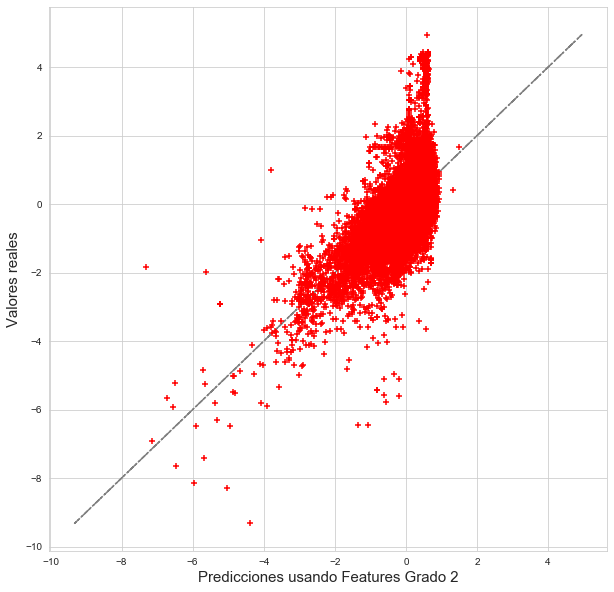

EMC: 0.6156563830723003


In [128]:
# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.figure(figsize=(10,10))
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando Features Grado 2",size = 15)
plt.ylabel("Valores reales",size = 15)
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))

In [129]:
model.rsquared

0.3843436169276998

### vemos que nos reporta sumary()

In [130]:
# son 3 tablas
model.summary().tables

[<class 'statsmodels.iolib.table.SimpleTable'>,
 <class 'statsmodels.iolib.table.SimpleTable'>,
 <class 'statsmodels.iolib.table.SimpleTable'>]

In [131]:
model.summary().tables[0]

Dep. Variable:,usd_m2,R-squared:,0.384
Model:,OLS,Adj. R-squared:,0.383
Method:,Least Squares,F-statistic:,289.9
Date:,"Tue, 05 May 2020",Prob (F-statistic):,0.00
Time:,13:08:35,Log-Likelihood:,-30115.
No. Observations:,25599,AIC:,6.034e+04
Df Residuals:,25543,BIC:,6.080e+04
Df Model:,55,,
Covariance Type:,nonrobust,,


In [132]:
# vemos la tabla 1 que nos muestra los p-value
sumario = pd.DataFrame(model.summary().tables[1],columns=['beta','coef','std_err','t','P_value_t','[0.025','0.975]'])[1:]
sumario.head()

,beta,coef,std_err,t,P_value_t,[0.025,0.975]
1,const,-9.576e+08,1.62e+09,-0.589,0.556,-4.14e+09,2.23e+09
2,x1,-1.484e+10,2.52e+10,-0.589,0.556,-6.42e+10,3.45e+10
3,x2,-1.226e+10,2.08e+10,-0.589,0.556,-5.3e+10,2.85e+10
4,x3,-5.457e+09,9.26e+09,-0.589,0.556,-2.36e+10,1.27e+10
5,x4,4.48e+10,7.6e+10,0.589,0.556,-1.04e+11,1.94e+11


tanto las tablas como las celdas son objetos de stats models, por lo que los vamos a convertir en algo que podamos trabajar

In [133]:
# objeto statsmodels
sumario.P_value_t.iloc[0]

In [134]:
# tienen un atributo .data
sumario.P_value_t.iloc[0].data

' 0.556'

In [135]:
# son de tipo str
type(sumario.P_value_t.iloc[0].data)

str

In [136]:
# podemos llevarlos a un float
float(sumario.P_value_t.iloc[0].data)

0.556

In [137]:
# para toda la columna de p_value
sumario.P_value_t = [float(sumario.P_value_t.iloc[x].data) for x in range(len(sumario))]

In [138]:
sumario.reset_index(inplace=True,drop=True)

In [139]:
sumario.head()

,beta,coef,std_err,t,P_value_t,[0.025,0.975]
0,const,-9.576e+08,1.62e+09,-0.589,0.556,-4.14e+09,2.23e+09
1,x1,-1.484e+10,2.52e+10,-0.589,0.556,-6.42e+10,3.45e+10
2,x2,-1.226e+10,2.08e+10,-0.589,0.556,-5.3e+10,2.85e+10
3,x3,-5.457e+09,9.26e+09,-0.589,0.556,-2.36e+10,1.27e+10
4,x4,4.48e+10,7.6e+10,0.589,0.556,-1.04e+11,1.94e+11


In [140]:
# menos la constante son 1364 filas (o sea features/columnas)
sumario.shape

(66, 7)

In [141]:
# con p_value mayor a 0.05 hay la mitad mas o menos
sumario.loc[sumario.P_value_t < 0.05].shape

(35, 7)

In [142]:
# vemos con que shapes estamos trabajando
shp_split(Xtr=X_train_grado2)

,split,rows,cols
X,train,25599,65
X,test,6400,10
y,train,25599,1
y,test,6400,1


In [143]:
# nos armamos una lista de features que dropeamos
betas_ok = sumario.loc[sumario.P_value_t < 0.05].index

lista_betas = list(betas_ok)

len(list(betas_ok))

35

In [144]:
# reconvertimos X en un dataframe para poder loquear
X = pd.DataFrame(X)

In [145]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.307016,-0.144835,0.835260,-1.070790,...,0.020977,-0.120975,0.155088,0.107084,0.697659,-0.894388,-0.617552,1.146591,0.791693,0.546644
1,1.0,0.439803,-0.261289,-0.211392,-5.869896,-0.027254,1.464753,2.992099,0.835260,0.507727,...,8.952655,2.499180,1.519170,3.578869,0.697659,0.424084,0.999060,0.257787,0.607296,1.430671
2,1.0,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.314873,-0.144835,0.835260,-0.720730,...,0.020977,-0.120975,0.104387,-0.223817,0.697659,-0.601997,1.290747,0.519451,-1.113761,2.388025
3,1.0,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.287373,0.313390,0.835260,-0.596076,...,0.098213,0.261762,-0.186804,-0.262755,0.697659,-0.497879,-0.700306,0.355307,0.499768,0.702963
4,1.0,0.439803,-0.261289,-0.211392,0.170361,-0.027254,0.007267,1.206293,-1.197232,-0.126484,...,1.455143,-1.444213,-0.152577,0.341664,1.433365,0.151431,-0.339097,0.015998,-0.035825,0.080222


In [146]:
X = X.reindex(lista_betas,axis=1)

In [147]:
X_train_grado2 = X.copy()

In [148]:
# vemos con que shapes estamos trabajando
shp_split(Xtr=X_train_grado2)

,split,rows,cols
X,train,25599,35
X,test,6400,10
y,train,25599,1
y,test,6400,1


#### con p-value < 0.05

In [149]:
# Instanciamos los modelos
lm = LinearRegression()

In [150]:
# Hacemos los fits respectivos
lm.fit(X_train_grado2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [151]:
# Calculamos el R2
print("R2 Score Train Lineal: %.5f\n" % lm.score(X_train_grado2, y_train))

R2 Score Train Lineal: 0.36000



### en test solo transform

In [152]:
X_test_grado2 = pol2.transform(X_test)

In [153]:
shp_split(Xte=X_test_grado2)

,split,rows,cols
X,train,25599,10
X,test,6400,65
y,train,25599,1
y,test,6400,1


In [154]:
# agrego la constante para evitar desfases de columnas
X_test_grado2 = sm.add_constant(X_test_grado2)

In [155]:
X_test_grado2 = pd.DataFrame(X_test_grado2)

In [156]:
X_test_grado2 = X_test_grado2.reindex(lista_betas,axis=1)

In [157]:
shp_split(Xte=X_test_grado2)

,split,rows,cols
X,train,25599,10
X,test,6400,35
y,train,25599,1
y,test,6400,1


In [158]:
y_test_predicted = lm.predict(X_test_grado2)

In [159]:
metricas(X_test_grado2, y_test, y_test_predicted)

MAE, Mean Absolute Error:       0.53172
MSE, Mean Square Error:         0.61717
RMSE, Root-Mean-Square Error:   0.78560
R2 Score Train Lineal:          0.35279


--------------------------------------------------------------------------------------------------------------------------------

## Con dummies de localización (sin lat lon)

In [160]:
df = pd.read_csv('df_limpio_modelo.csv',sep='|')

In [161]:
df.shape

(31999, 73)

In [162]:
df.head()

,usd_m2,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,1,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,1,0,99.871429,3.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,1,0,0,1,0,45.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,1,0,0,1,0,65.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0


### 5. Obtención de matriz de features (X) y vector de variable explicada (y)

Observamos las columnas de nuestro dataset actual

In [163]:
df.columns

Index(['usd_m2', 'precio_usd', 'prop_apartment', 'prop_house', 'prop_store',
       'size_normal', 'size_xl', 'superficie_m2', 'ambientes', 'amenities',
       'lat', 'lon', 'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera',
       'loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
       'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas',
       'loc_Centro / Microcentro', 'loc_Chacarita', 'loc_Coghlan',
       'loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores',
       'loc_Floresta', 'loc_Las Cañitas', 'loc_Liniers', 'loc_Mataderos',
       'loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once',
       'loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood',
       'loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
       'loc_Parque Centenario', 'loc_Parque Chacabuco', 'loc_Parque Chas',
       'loc_Parque Patricios', 'loc_Paternal', 'loc_Pompeya',
       'loc_Puerto Madero', 'loc_Recoleta', 'loc_Retiro', 'loc_Saa

La columna usd_m2 representa el precio por metro cuadrado en dólares. Esta va a ser nuestra variable **target**, a la que llamaremos y.

Las columnas de superficie, ambientes y expensas, sumadas a las dummies correspondientes a las variables categóricas de subtipo de propiedad y localidad, son las posibles variables explicativas que nos permitiran llegar al valor de nuestra y. Estas serán nuestras **features** y estarán en la matriz X.


In [164]:
y = df[['usd_m2']]
feature_cols = ['precio_usd',
                
                'prop_apartment', 'prop_house', 'prop_store','size_normal', 'size_xl', 'superficie_m2', 'ambientes', 'amenities',
                
                'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera','loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
                'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas','loc_Centro / Microcentro','loc_Chacarita',
                'loc_Coghlan', 'loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores','loc_Floresta',
                'loc_Las Cañitas', 'loc_Liniers', 'loc_Mataderos','loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez',
                'loc_Once','loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood','loc_Palermo Soho',
                'loc_Palermo Viejo', 'loc_Parque Avellaneda','loc_Parque Centenario', 'loc_Parque Chacabuco',
                'loc_Parque Chas','loc_Parque Patricios', 'loc_Paternal', 'loc_Pompeya', 'loc_Puerto Madero',
                'loc_Recoleta', 'loc_Retiro', 'loc_Saavedra','loc_San Cristobal', 'loc_San Nicolás', 'loc_San Telmo',
                'loc_Tribunales', 'loc_Velez Sarsfield', 'loc_Versalles','loc_Villa Crespo', 'loc_Villa Devoto',
                'loc_Villa General Mitre', 'loc_Villa Lugano', 'loc_Villa Luro', 'loc_Villa Ortuzar','loc_Villa Pueyrredón',
                'loc_Villa Real', 'loc_Villa Riachuelo', 'loc_Villa Santa Rita', 'loc_Villa Soldati', 'loc_Villa Urquiza',
                'loc_Villa del Parque']

In [165]:
X = df[feature_cols]

In [166]:
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Type X:", type(X))
print("Type y:", type(y))

Shape X: (31999, 70)
Shape y: (31999, 1)
Type X: <class 'pandas.core.frame.DataFrame'>
Type y: <class 'pandas.core.frame.DataFrame'>


In [167]:
X.sample()

,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,loc_Agronomía,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
8278,152000.0,1,0,0,1,0,76.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
y.head()

,usd_m2
0,1127.272727
1,1309.090909
2,951.223001
3,3066.666667
4,3000.000000


### 6. División de dataset en train-test para validación de modelo

Creamos una columna para estatificar, y splitear con ella.

In [169]:
X['usd_stratify'] = pd.qcut(X['precio_usd'],4,labels=[1,2,3,4])

X = X[[x for x in X.columns if (x!='precio_usd')]]

C:\Users\mmili\.conda\envs\manu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Dividimos en train-test

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['usd_stratify'],test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25599, 70) (25599, 1)
(6400, 70) (6400, 1)


In [171]:
X_train.drop('usd_stratify', axis=1, inplace=True)
X_test.drop('usd_stratify', axis=1, inplace=True)

C:\Users\mmili\.conda\envs\manu\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 7. Normalización de variables por estandarización para el set de train

Apliquemos estandarización, transformando las variables para que tengan media 0 $(\mu = 0)$ y desvío estándar 1 $(\sigma = 1)$, aplicando la fórmula:

$$ x' = \frac{x - \mu}{\sigma}$$

Estandarizamos feautures:

In [172]:
X_train.head()

,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,loc_Agronomía,loc_Almagro,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
22595,1,0,0,1,0,32.0,2.486814,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2279,1,0,0,0,0,483.0,6.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29149,1,0,0,1,0,30.0,2.486814,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14613,1,0,0,1,0,37.0,3.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2631,1,0,0,1,0,112.0,4.000000,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [173]:
# Fiteamos el estandarizador y estandarizamos con X_train

stdscaler_X = preprocessing.StandardScaler()
X_train_scaled = stdscaler_X.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Estandarizamos X_test con el estandarizador fiteado con X_train

X_test_scaled = stdscaler_X.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE


Estandarizamos target y lo centramos con una fución logarítmica, ya que su distribución es asimétrica con cola a la derecha:


In [174]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [175]:
# Fiteamos el estandarizador y estandarizamos con y_train

stdscaler_y = preprocessing.StandardScaler()
y_train_scaled = stdscaler_y.fit_transform(y_train)
y_train = pd.DataFrame(y_train_scaled, columns=y_train.columns)

# Estandarizamos y_test con el estandarizador fiteado con y_train

y_test_scaled = stdscaler_y.transform(y_test)
y_test = pd.DataFrame(y_test_scaled, columns=y_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE

Vemos que todo esté bien

Verificamos que estén normalizadas y verificamos que:

   + $\bar{x_{j}} \approx 0$
    
   + $s_{j}=1.00002$

In [176]:
X_train.apply(['mean','std']).T

,mean,std
prop_apartment,1.312890e-16,1.00002
prop_house,-2.525856e-17,1.00002
prop_store,2.886693e-17,1.00002
size_normal,2.567491e-16,1.00002
size_xl,-1.332320e-17,1.00002
...,...,...
loc_Villa Riachuelo,-6.314640e-18,1.00002
loc_Villa Santa Rita,9.853614e-18,1.00002
loc_Villa Soldati,-9.714831e-18,1.00002
loc_Villa Urquiza,3.185077e-17,1.00002


In [177]:
y_train.apply(['mean','std']).T

,mean,std
usd_m2,-1.457225e-15,1.00002


## 8. Prueba de distintos modelos (con el set de train) y evaluación de la performance con el set de test (MAE, MSE, RMSE, R2)
  
b. Con dummies de localización (sin lat-lon)

    I)   Sin regularización, descartando variables no significativas con stats model
   
    II)  Ridge (optimizamos parámetros usando cross-validation de forma automática con k grupos)

    III) Lasso (optimizamos parámetros usando cross-validation de forma automática con k grupos)

    IV)   Sin regularización pero con PCA previo 

## 8.b. Con dummies de localización (sin lat-lon)

### 8.b. I) Modelo básico de regresión lineal


Primero chequeamos que están las columnas 'lat' y 'lon' y para esta parte del ejercicio las borramos tanto del subset "Train" como del subset "Test"

In [178]:
X_train.columns

Index(['prop_apartment', 'prop_house', 'prop_store', 'size_normal', 'size_xl',
       'superficie_m2', 'ambientes', 'amenities', 'loc_Agronomía',
       'loc_Almagro', 'loc_Balvanera', 'loc_Barracas', 'loc_Barrio Norte',
       'loc_Belgrano', 'loc_Boca', 'loc_Boedo', 'loc_Caballito',
       'loc_Capital Federal', 'loc_Catalinas', 'loc_Centro / Microcentro',
       'loc_Chacarita', 'loc_Coghlan', 'loc_Colegiales', 'loc_Congreso',
       'loc_Constitución', 'loc_Flores', 'loc_Floresta', 'loc_Las Cañitas',
       'loc_Liniers', 'loc_Mataderos', 'loc_Monserrat', 'loc_Monte Castro',
       'loc_Nuñez', 'loc_Once', 'loc_Palermo', 'loc_Palermo Chico',
       'loc_Palermo Hollywood', 'loc_Palermo Soho', 'loc_Palermo Viejo',
       'loc_Parque Avellaneda', 'loc_Parque Centenario',
       'loc_Parque Chacabuco', 'loc_Parque Chas', 'loc_Parque Patricios',
       'loc_Paternal', 'loc_Pompeya', 'loc_Puerto Madero', 'loc_Recoleta',
       'loc_Retiro', 'loc_Saavedra', 'loc_San Cristobal', 'loc_San 

### Analizamos la regresión lineal con statsmodel para eliminar variables con coeficientes no significativos

a) Estimamos el modelo sin intercepto ya que para este caso probó no ser significativo

In [179]:
import statsmodels.api as sm

In [180]:
X = X_train 

y = y_train[['usd_m2']]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

EMC: 0.512735351360031
                            OLS Regression Results                            
Dep. Variable:                 usd_m2   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     351.6
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        13:08:41   Log-Likelihood:                -27773.
No. Observations:               25599   AIC:                         5.569e+04
Df Residuals:                   25529   BIC:                         5.626e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
c

Hay algunas variables cuyo p-value mayor a 0,05 hace que tengan una asociación con el y target que puede ser producto del azar así que las eliminamos

In [181]:
# vemos la tabla 1 que nos muestra los p-value
sumario = pd.DataFrame(model.summary().tables[1],columns=['beta','coef','std_err','t','P_value_t','[0.025','0.975]'])[1:]
sumario.head()

,beta,coef,std_err,t,P_value_t,[0.025,0.975]
1,const,-1.123e-15,0.004,-2.51e-13,1.000,-0.009,0.009
2,prop_apartment,0.1460,0.008,18.906,0.000,0.131,0.161
3,prop_house,-0.0358,0.007,-5.329,0.000,-0.049,-0.023
4,prop_store,0.0447,0.006,7.212,0.000,0.033,0.057
5,size_normal,0.0753,0.005,14.654,0.000,0.065,0.085


tanto las tablas como las celdas son objetos de stats models, por lo que los vamos a convertir en algo que podamos trabajar

In [182]:
# para toda la columna de p_value
sumario.P_value_t = [float(sumario.P_value_t.iloc[x].data) for x in range(len(sumario))]

In [183]:
# para toda la columna beta, convertimos los objetos model en strings
sumario.beta = [str(sumario.beta.iloc[x].data) for x in range(len(sumario))]

In [184]:
sumario.reset_index(inplace=True,drop=True)

In [185]:
sumario.head()

,beta,coef,std_err,t,P_value_t,[0.025,0.975]
0,const,-1.123e-15,0.004,-2.51e-13,1.0,-0.009,0.009
1,prop_apartment,0.1460,0.008,18.906,0.0,0.131,0.161
2,prop_house,-0.0358,0.007,-5.329,0.0,-0.049,-0.023
3,prop_store,0.0447,0.006,7.212,0.0,0.033,0.057
4,size_normal,0.0753,0.005,14.654,0.0,0.065,0.085


In [186]:
# menos la constante son 1364 filas (o sea features/columnas)
sumario.shape

(70, 7)

In [187]:
# con p_value mayor a 0.05 hay la mitad mas o menos
sumario.loc[sumario.P_value_t < 0.05].shape

(46, 7)

In [188]:
# nos armamos una lista de features que dropeamos
betas_ok = sumario.loc[sumario.P_value_t < 0.05].beta.unique()

lista_betas = list(betas_ok)

len(list(betas_ok))

46

In [189]:
betas_ok

array(['prop_apartment', 'prop_house', 'prop_store', 'size_normal',
       'size_xl', 'superficie_m2', 'ambientes', 'amenities',
       'loc_Balvanera', 'loc_Barracas', 'loc_Barrio Norte',
       'loc_Belgrano', 'loc_Boca', 'loc_Boedo', 'loc_Caballito',
       'loc_Catalinas', 'loc_Coghlan', 'loc_Colegiales', 'loc_Congreso',
       'loc_Constitución', 'loc_Floresta', 'loc_Las Cañitas',
       'loc_Liniers', 'loc_Mataderos', 'loc_Nuñez', 'loc_Once',
       'loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood',
       'loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
       'loc_Parque Centenario', 'loc_Parque Chacabuco',
       'loc_Parque Patricios', 'loc_Pompeya', 'loc_Puerto Madero',
       'loc_Recoleta', 'loc_Retiro', 'loc_Saavedra', 'loc_San Cristobal',
       'loc_Tribunales', 'loc_Villa Crespo', 'loc_Villa Lugano',
       'loc_Villa Soldati', 'loc_Villa Urquiza'], dtype=object)

In [190]:
X_train = X.loc[:,lista_betas]

Después de sacar del modelo las variables que no son significativas corremos de nuevo el modelo

In [191]:
X = X_train 
y = y_train[['usd_m2']]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary().tables[0])

EMC: 0.5156287801631595
                                 OLS Regression Results                                
Dep. Variable:                 usd_m2   R-squared (uncentered):                   0.484
Model:                            OLS   Adj. R-squared (uncentered):              0.483
Method:                 Least Squares   F-statistic:                              521.8
Date:                Tue, 05 May 2020   Prob (F-statistic):                        0.00
Time:                        13:08:42   Log-Likelihood:                         -27845.
No. Observations:               25599   AIC:                                  5.578e+04
Df Residuals:                   25553   BIC:                                  5.616e+04
Df Model:                          46                                                  
Covariance Type:            nonrobust                                                  


Ahora que tenemos un modelo con todas las variables significtivas borramos esas mismas columnas en el subset "Test"

In [192]:
X_test = X_test.loc[:,lista_betas]

Corremos el modelo de regresión lineal para el subset "Test"

In [193]:
X = X_test 
y = y_test[['usd_m2']]

predictions_test = model.predict(X)
print ("EMC:", mean_squared_error(y, predictions_test))
print (model.summary().tables[0])

EMC: 0.4869213047699955
                                 OLS Regression Results                                
Dep. Variable:                 usd_m2   R-squared (uncentered):                   0.484
Model:                            OLS   Adj. R-squared (uncentered):              0.483
Method:                 Least Squares   F-statistic:                              521.8
Date:                Tue, 05 May 2020   Prob (F-statistic):                        0.00
Time:                        13:08:43   Log-Likelihood:                         -27845.
No. Observations:               25599   AIC:                                  5.578e+04
Df Residuals:                   25553   BIC:                                  5.616e+04
Df Model:                          46                                                  
Covariance Type:            nonrobust                                                  


Queremos saber cual es el R2 para el subset "Test". Para ello, realizamos una serie de pasos previos utilizando la libería Sci-kit Learn

En primer lugar instanciamos el modelo sin intercepto

In [194]:
lm2 = LinearRegression(fit_intercept=False)

Ajustamos el modelo,para que aprenda los datos del subset de Train

In [195]:
model2 = lm2.fit(X_train, y_train)

Calculamos los coeficientes. Naturalmente son iguales que los obtenidos anteriormente con la libería Statsmodel porque estamos estimando el mismo modelo de regresión lineal múltiple de dos maneras distintas

In [196]:
np.set_printoptions(precision=3, suppress=True)

print('Intercept Linear model: ',lm2.intercept_,'\n',
      'Coefs Linear model:',lm2.coef_,'\n')

Intercept Linear model:  0.0 
 Coefs Linear model: [[ 0.147 -0.04   0.044  0.077  0.089 -0.3   -0.122  0.053 -0.025 -0.029
   0.089  0.178 -0.033  0.258  0.058  0.01   0.027  0.038 -0.028 -0.039
  -0.021  0.059 -0.032 -0.054  0.082 -0.027  0.159  0.122  0.07   0.058
   0.029 -0.015  0.013 -0.014 -0.028 -0.037  0.273  0.148  0.031  0.029
   0.18  -0.011  0.045 -0.063 -0.01   0.065]] 



Calculamos el R2 y las distintas medidas de error de pronóstico (MAE, MSE, RMSE) 

In [197]:
# Calculamos el R2
print(" Score Train Lineal: %.5f\n" % lm2.score(X_train, y_train))

# Calculamos el RMSE
y_pred_tr_lm2 = lm2.predict(X_train)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
print(" Train RMSE lineal   : %.5f \n" % rmse(y_train,y_pred_tr_lm2))

# Calculamos el MAE
print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lm2))

# Calculamos el MSE
print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lm2))

 Score Train Lineal: 0.48437

 Train RMSE lineal   : 0.71807 

 MAE: 0.47685

 MSE: 0.51563



Hacemos las predicciones sobre la matriz de predictores del Test Set y obtenemos el R2 del modelo de regresión lineal básico

In [198]:
y_pred_lm2 = lm2.predict(X_test)

print(" Score Test Lineal: %.5f\n" % lm2.score(X_test, y_test))
print(" Test RMSE lineal= %.5f\n" % rmse(y_test, y_pred_lm2))

 Score Test Lineal: 0.48938

 Test RMSE lineal= 0.69780



# persistencia
exportamos los objetos necesarios para realizar una prediccion con nuevos datos

Luego del analisis posterior se llega a la conclusión de que este será el mejor modelo en cuanto a performance...
para poder acceder a él luego de las siguientes pruebas guardamos los elementos utilizados en variables mas especificas

In [199]:
# guardamos los elementos que nos permitirán predecir el modelo elegido
X_train_selec = X_train.copy()
X_test_selec = X_test.copy()
y_train_selec = y_train.copy()
y_test_selec = y_test.copy()

stdscaler_X_selec = stdscaler_X
stdscaler_y_selec = stdscaler_y

model_selected = model2
features_needed = feature_cols[1:]

In [200]:
# generamos una lista para exportar a pickle
objetos_pk = [model_selected,features_needed,lista_betas,stdscaler_X_selec,stdscaler_y_selec]

In [201]:
import pickle

In [202]:
# exportamos el modelo
with open('objetos_pk.pkl', 'wb') as objetos:
    pickle.dump(objetos_pk, objetos)

### 8.b. II) Modelo básico de regresión lineal con factor de penalización Ridge

#### Aplico factor de penalización Ridge para evitar overfitting (Se setea el modelo para que optimice parámetros usando cross-validation de forma automática con k grupos)

Instanciamos el modelo, generando un grid de $\alpha$ para probar e instanciamos un particionador en k partes para la cross-validation

In [203]:
al_ridge = np.linspace(0.001, 0.3, 300)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)

Fiteamos el modelo, para que aprenda de los datos. 

In [204]:
lm_ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.0...
       0.262, 0.263, 0.264, 0.265, 0.266, 0.267, 0.268, 0.269, 0.27 ,
       0.271, 0.272, 0.273, 0.274, 0.275, 0.276, 0.277, 0.278, 0.279,
       0.28 , 0.281, 0.282, 0.283, 0.284, 0.285, 0.286, 0.287, 0.288,
       0.289, 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297,
       0.298, 0.299, 0.3  ]),
        cv=KFold(n_splits=5, random_state=0, shuffle=True), fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

EL modelo ya determina sus coeficientes de regresión y su hiperparámetro. Los vemos

In [205]:
np.set_printoptions(precision=3, suppress=True)

print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n',
      'Intercept Ridge: ',lm_ridge_cv.intercept_,'\n',
      'Coefs Ridge:',lm_ridge_cv.coef_,'\n')


Alpha Ridge: 0.3 
 Intercept Ridge:  [-0.] 
 Coefs Ridge: [[ 0.147 -0.04   0.044  0.077  0.089 -0.3   -0.122  0.053 -0.025 -0.029
   0.089  0.178 -0.033  0.258  0.058  0.01   0.027  0.038 -0.028 -0.039
  -0.021  0.059 -0.032 -0.054  0.082 -0.027  0.159  0.122  0.07   0.058
   0.029 -0.015  0.013 -0.014 -0.028 -0.037  0.273  0.148  0.031  0.029
   0.18  -0.011  0.045 -0.063 -0.01   0.065]] 



Vemos la performance del modelo sobre sus propios datos de "Train"

In [206]:
# Calculamos el R2
print("Score Train Ridge : %.5f\n" % lm_ridge_cv.score(X_train, y_train))

# Calculamos el RMSE
y_pred_tr_ridge = lm_ridge_cv.predict(X_train)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
print("Train RMSE Ridge    : %.5f \n" % rmse(y_train,y_pred_tr_ridge))

# Calculamos el MAE
print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_ridge))

# Calculamos el MSE
print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_ridge))

Score Train Ridge : 0.48437

Train RMSE Ridge    : 0.71807 

 MAE: 0.47685

 MSE: 0.51563



Aplicamos el modelo sobre el set "Test"

In [207]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_ridge = lm_ridge_cv.predict(X_test)

print(" Score Test Ridge: %.5f\n" % lm_ridge_cv.score(X_test, y_test))
print(" Test RMSE Ridge= %.f\n" % rmse(y_test, y_pred_ridge))
print (' MSE: %.5f\n' % metrics.mean_squared_error(y_test, y_pred_ridge))

 Score Test Ridge: 0.48938

 Test RMSE Ridge= 1

 MSE: 0.48692



### 8.b. III) Modelo básico de regresión lineal con factor de penalización Lasso

#### Aplico factor de penalización Lasso para evitar overfitting (Se setea el modelo para que optimice parámetros usando cross-validation de forma automática con k grupos)

De la misma forma que antes, hacemos:

In [208]:
al_lasso = np.linspace(0.1, 0.5, 300)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

In [209]:
lm_lasso_cv.fit(X_train, y_train)

C:\Users\mmili\.conda\envs\manu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1088: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LassoCV(alphas=array([0.1  , 0.101, 0.103, 0.104, 0.105, 0.107, 0.108, 0.109, 0.111,
       0.112, 0.113, 0.115, 0.116, 0.117, 0.119, 0.12 , 0.121, 0.123,
       0.124, 0.125, 0.127, 0.128, 0.129, 0.131, 0.132, 0.133, 0.135,
       0.136, 0.137, 0.139, 0.14 , 0.141, 0.143, 0.144, 0.145, 0.147,
       0.148, 0.149, 0.151, 0.152, 0.154, 0.155, 0.156, 0.158, 0.159,
       0.16 , 0.162, 0.163, 0.164, 0.166, 0.167, 0.168, 0.17 , 0.171,
       0.172, 0.17...
       0.473, 0.475, 0.476, 0.477, 0.479, 0.48 , 0.481, 0.483, 0.484,
       0.485, 0.487, 0.488, 0.489, 0.491, 0.492, 0.493, 0.495, 0.496,
       0.497, 0.499, 0.5  ]),
        copy_X=True, cv=KFold(n_splits=5, random_state=0, shuffle=True),
        eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Imprimimos los coeficientes y vemos que con Lasso busca el menor $\alpha$

In [210]:
np.set_printoptions(precision=3, suppress=True)

print('Alpha Lasso:',lm_lasso_cv.alpha_,'\n'
      'Intercept Lasso: ',lm_ridge_cv.intercept_,'\n'
      'Coefs Lasso:',lm_lasso_cv.coef_,'\n')

Alpha Lasso: 0.1 
Intercept Lasso:  [-0.] 
Coefs Lasso: [ 0.156 -0.043  0.     0.     0.    -0.202 -0.066  0.    -0.    -0.
  0.     0.004 -0.     0.134 -0.     0.     0.     0.    -0.    -0.
 -0.     0.    -0.    -0.     0.    -0.     0.     0.     0.     0.
  0.    -0.    -0.    -0.    -0.    -0.     0.131  0.     0.    -0.
  0.052 -0.    -0.    -0.    -0.     0.   ] 



Vemos la performance del modelo sobre sus propios datos de "Train" 

In [211]:
# Calculamos el R2
print("Score Train Lasso : %.5f\n" % lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE
y_pred_tr_lasso = lm_lasso_cv.predict(X_train)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
print("Train RMSE Lasso    : %.5f \n" % rmse(y_train,y_pred_tr_lasso))

# Calculamos el MAE
print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lasso))

# Calculamos el MSE
print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lasso))

Score Train Lasso : 0.31715

Train RMSE Lasso    : 0.82635 

 MAE: 0.57227

 MSE: 0.68285



Sobre el set Test. Notamos que el R2 es significativamente menor tanto con respecto al modelo de regresión lineal simple como con respecto al que aplicamos Ridge

In [212]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lasso = lm_lasso_cv.predict(X_test)

print(" Score Test Lasso: %.5f\n" % lm_lasso_cv.score(X_test, y_test))
print(" Test RMSE Lasso= %.f\n" % rmse(y_test, y_pred_lasso))
print (' MSE: %.5f\n' % metrics.mean_squared_error(y_test, y_pred_lasso))

 Score Test Lasso: 0.31109

 Test RMSE Lasso= 1

 MSE: 0.65693



## 8.b. IV) Sin regularización pero con PCA previo

In [213]:
df = pd.read_csv('df_limpio_modelo.csv',sep='|')

In [214]:
df.head()

,usd_m2,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,1127.272727,62000.0,0,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
1,1309.090909,72000.0,1,0,0,1,0,55.000000,2.000000,0,...,0,0,0,0,0,0,0,0,0,0
2,951.223001,95000.0,0,0,0,1,0,99.871429,3.000000,0,...,0,0,0,0,0,0,0,0,0,0
3,3066.666667,138000.0,1,0,0,1,0,45.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0
4,3000.000000,195000.0,1,0,0,1,0,65.000000,2.486814,1,...,0,0,0,0,0,0,0,0,0,0


### 5. Obtención de matriz de features (X) y vector de variable explicada (y)

Observamos las columnas de nuestro dataset actual

In [215]:
df.columns

Index(['usd_m2', 'precio_usd', 'prop_apartment', 'prop_house', 'prop_store',
       'size_normal', 'size_xl', 'superficie_m2', 'ambientes', 'amenities',
       'lat', 'lon', 'loc_Agronomía', 'loc_Almagro', 'loc_Balvanera',
       'loc_Barracas', 'loc_Barrio Norte', 'loc_Belgrano', 'loc_Boca',
       'loc_Boedo', 'loc_Caballito', 'loc_Capital Federal', 'loc_Catalinas',
       'loc_Centro / Microcentro', 'loc_Chacarita', 'loc_Coghlan',
       'loc_Colegiales', 'loc_Congreso', 'loc_Constitución', 'loc_Flores',
       'loc_Floresta', 'loc_Las Cañitas', 'loc_Liniers', 'loc_Mataderos',
       'loc_Monserrat', 'loc_Monte Castro', 'loc_Nuñez', 'loc_Once',
       'loc_Palermo', 'loc_Palermo Chico', 'loc_Palermo Hollywood',
       'loc_Palermo Soho', 'loc_Palermo Viejo', 'loc_Parque Avellaneda',
       'loc_Parque Centenario', 'loc_Parque Chacabuco', 'loc_Parque Chas',
       'loc_Parque Patricios', 'loc_Paternal', 'loc_Pompeya',
       'loc_Puerto Madero', 'loc_Recoleta', 'loc_Retiro', 'loc_Saa

La columna usd_m2 representa el precio por metro cuadrado en dólares. Esta va a ser nuestra variable **target**, a la que llamaremos y.

Las columnas de superficie, ambientes y expensas, sumadas a las dummies correspondientes a las variables categóricas de subtipo de propiedad y localidad, son las posibles variables explicativas que nos permitiran llegar al valor de nuestra y. Estas serán nuestras **features** y estarán en la matriz X.


In [216]:
y = df[['usd_m2']]

X = df.drop(['usd_m2'], axis=1)

In [217]:
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Type X:", type(X))
print("Type y:", type(y))

Shape X: (31999, 72)
Shape y: (31999, 1)
Type X: <class 'pandas.core.frame.DataFrame'>
Type y: <class 'pandas.core.frame.DataFrame'>


In [218]:
X.head()

,precio_usd,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,lat,...,loc_Villa Lugano,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque
0,62000.0,0,0,0,1,0,55.000000,2.000000,0,-34.661824,...,0,0,0,0,0,0,0,0,0,0
1,72000.0,1,0,0,1,0,55.000000,2.000000,0,-34.652262,...,0,0,0,0,0,0,0,0,0,0
2,95000.0,0,0,0,1,0,99.871429,3.000000,0,-34.647797,...,0,0,0,0,0,0,0,0,0,0
3,138000.0,1,0,0,1,0,45.000000,2.486814,1,-34.559873,...,0,0,0,0,0,0,0,0,0,0
4,195000.0,1,0,0,1,0,65.000000,2.486814,1,-34.559873,...,0,0,0,0,0,0,0,0,0,0


In [219]:
y

,usd_m2
0,1127.272727
1,1309.090909
2,951.223001
3,3066.666667
4,3000.000000
...,...
31994,2611.464968
31995,2611.464968
31996,1952.098179
31997,2858.695652


### 6. División de dataset en train-test para validación de modelo

Creamos una columna para estatificar, y splitear con ella.

In [220]:
X['usd_stratify'] = pd.qcut(X['precio_usd'],4,labels=[1,2,3,4])

X = X[[x for x in X.columns if (x!='precio_usd')]]

Dividimos en train-test

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['usd_stratify'],test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25599, 72) (25599, 1)
(6400, 72) (6400, 1)


In [222]:
X = X[[x for x in X.columns if (x!='usd_stratify')]]

### 7. Normalización de variables por estandarización para el set de train

Apliquemos estandarización, transformando las variables para que tengan media 0 $(\mu = 0)$ y desvío estándar 1 $(\sigma = 1)$, aplicando la fórmula:

$$ x' = \frac{x - \mu}{\sigma}$$

Estandarizamos feautures:

In [223]:
# Fiteamos el estandarizador y estandarizamos con X_train

stdscaler_X = preprocessing.StandardScaler()
X_train_scaled = stdscaler_X.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Estandarizamos X_test con el estandarizador fiteado con X_train

X_test_scaled = stdscaler_X.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE


Estandarizamos target y lo centramos con una fución logarítmica, ya que su distribución es asimétrica con cola a la derecha:


In [224]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [225]:

# Fiteamos el estandarizador y estandarizamos con y_train

stdscaler_y = preprocessing.StandardScaler()
y_train_scaled = stdscaler_y.fit_transform(y_train)
y_train = pd.DataFrame(y_train_scaled, columns=y_train.columns)

# Estandarizamos y_test con el estandarizador fiteado con y_train

y_test_scaled = stdscaler_y.transform(y_test)
y_test = pd.DataFrame(y_test_scaled, columns=y_test.columns)

#UTILIZAR INVERSE_TRANSFORM PARA ANALIZAR LOS DATOS OBTENIDOS POSTERIORMENTE

Vemos que todo esté bien

In [226]:
display(X_train)

,prop_apartment,prop_house,prop_store,size_normal,size_xl,superficie_m2,ambientes,amenities,lat,lon,...,loc_Villa Luro,loc_Villa Ortuzar,loc_Villa Pueyrredón,loc_Villa Real,loc_Villa Riachuelo,loc_Villa Santa Rita,loc_Villa Soldati,loc_Villa Urquiza,loc_Villa del Parque,usd_stratify
0,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.307016,-0.144835,0.835260,-1.070790,-0.739354,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,-1.334790
1,0.439803,-0.261289,-0.211392,-5.869896,-0.027254,1.464753,2.992099,0.835260,0.507727,1.196107,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,1.350208
2,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.314873,-0.144835,0.835260,-0.720730,1.545324,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,-0.439790
3,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.287373,0.313390,0.835260,-0.596076,-0.838429,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,-1.334790
4,0.439803,-0.261289,-0.211392,0.170361,-0.027254,0.007267,1.206293,-1.197232,-0.126484,0.283234,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,0.455209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25594,-2.273746,3.827180,-0.211392,0.170361,-0.027254,-0.157732,-0.579513,0.835260,2.134964,-1.136519,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,-0.439790
25595,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.169517,-0.144835,-1.197232,-1.205630,1.870297,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,-0.439790
25596,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.248088,-0.579513,0.835260,1.055636,-0.261855,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,-0.439790
25597,0.439803,-0.261289,-0.211392,0.170361,-0.027254,-0.244160,-0.579513,-1.197232,0.436571,0.984410,...,-0.115847,-0.051227,-0.073889,-0.034253,-0.013977,-0.041964,-0.021656,-0.23233,-0.124219,0.455209


In [227]:
y_train

,usd_m2
0,0.063505
1,-2.325969
2,0.045897
3,-0.051567
4,-0.502603
...,...
25594,-0.316124
25595,-0.480667
25596,0.341347
25597,0.946237


Verificamos que estén normalizadas y verificamos que:

   + $\bar{x_{j}} \approx 0$
    
   + $s_{j}=1.00002$

In [228]:
X_train.apply(['mean','std']).T

,mean,std
prop_apartment,1.312890e-16,1.00002
prop_house,-2.525856e-17,1.00002
prop_store,2.886693e-17,1.00002
size_normal,2.567491e-16,1.00002
size_xl,-1.332320e-17,1.00002
...,...,...
loc_Villa Santa Rita,9.853614e-18,1.00002
loc_Villa Soldati,-9.714831e-18,1.00002
loc_Villa Urquiza,3.185077e-17,1.00002
loc_Villa del Parque,1.484981e-17,1.00002


In [229]:
y_train.apply(['mean','std']).T

,mean,std
usd_m2,-1.457225e-15,1.00002


In [230]:
from sklearn.decomposition import PCA

# Instanciamos la clase PCA:
pca_prop = PCA()

# Al no especificar el número de componentes, PCA va a conservar todos los CP.

# Calculamos los componentes principales con el método fit()
pca_prop.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [231]:
# Creamos un DataFRame con los loadings:

pca_loadings = pd.DataFrame(pca_prop.components_.T,index=X_train.columns)
pca_loadings

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
prop_apartment,-0.453664,-0.098193,0.118972,0.332298,-0.074897,-0.149447,0.035292,-0.014177,0.016154,0.024352,...,0.136414,-0.017098,0.091875,0.137939,0.325079,-0.043108,-0.667223,-0.015546,-0.005480,0.002954
prop_house,0.420404,0.013304,-0.113284,-0.043560,-0.183125,0.189206,-0.269429,0.049144,0.026862,0.078583,...,-0.226075,0.223428,0.083999,-0.490443,-0.077556,-0.051947,-0.525237,-0.002170,-0.000375,-0.000605
prop_store,0.172938,0.095067,0.062567,-0.448794,0.384583,0.083133,0.259899,-0.079213,-0.036818,-0.083826,...,0.060916,-0.139782,-0.309636,0.198566,-0.048689,0.082111,-0.480004,-0.015267,-0.002593,0.000723
size_normal,-0.230799,0.116029,-0.196962,-0.302708,-0.083041,0.121577,0.035183,0.060601,0.002845,0.122430,...,0.007772,0.657587,0.095975,0.264851,0.175879,0.292435,0.023391,0.004051,0.002086,-0.000695
size_xl,0.177740,-0.010762,0.117796,0.407314,0.394928,-0.042009,0.143156,0.053820,-0.008682,0.052744,...,0.063885,0.470714,0.157811,0.186758,-0.408903,-0.258015,-0.062171,0.002319,0.004492,-0.000285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
loc_Villa Santa Rita,0.014349,0.010726,-0.038619,-0.008280,-0.007075,0.004774,-0.017360,0.011155,0.002572,0.013478,...,0.025570,-0.018074,-0.017871,0.021426,0.015366,-0.005783,-0.011623,0.036467,0.010143,-0.044545
loc_Villa Soldati,0.060759,0.023375,0.025989,0.183540,0.209930,-0.055849,0.164299,0.057617,-0.029662,0.067158,...,-0.033830,-0.261554,-0.081903,-0.021721,-0.020008,-0.047598,-0.006935,0.011499,0.035524,-0.022217
loc_Villa Urquiza,-0.052978,-0.156697,-0.186531,0.041669,0.134976,0.017309,-0.059252,0.109803,0.435096,-0.153741,...,-0.137189,-0.038657,0.034465,0.029956,0.023555,-0.034188,0.000934,0.145066,-0.201129,-0.236146
loc_Villa del Parque,0.013310,-0.009082,-0.112088,0.038997,-0.041446,0.022333,0.073314,0.002581,-0.002233,-0.098749,...,0.031850,-0.032523,0.051297,-0.035836,0.011952,-0.006645,-0.002757,0.119084,-0.000712,-0.131443


In [232]:
# Verificamos la ortonormalidad de los componentes principales:

pca_loadings.T.dot(pca_loadings)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.000000e+00,-1.665335e-16,1.665335e-16,1.665335e-16,-1.526557e-16,3.469447e-17,-5.551115e-17,2.602085e-17,-1.734723e-18,6.245005e-17,...,5.898060e-17,9.020562e-17,1.769418e-16,-2.359224e-16,1.387779e-17,-5.551115e-17,-3.955170e-16,2.818926e-18,1.225148e-16,1.734723e-18
1,-1.665335e-16,1.000000e+00,-1.457168e-16,6.106227e-16,9.714451e-17,2.498002e-16,-6.938894e-17,1.387779e-16,-5.204170e-17,-1.179612e-16,...,-1.838807e-16,-3.608225e-16,1.387779e-17,-5.551115e-17,8.881784e-16,8.326673e-17,3.053113e-16,-3.124671e-16,-9.562663e-17,1.973248e-17
2,1.665335e-16,-1.457168e-16,1.000000e+00,-3.538836e-16,1.457168e-16,-1.092876e-16,-2.775558e-17,1.387779e-17,4.597017e-17,5.551115e-17,...,7.979728e-17,5.551115e-17,1.543904e-16,-1.942890e-16,-5.967449e-16,-5.551115e-17,-2.393918e-16,1.019150e-17,-7.936360e-17,1.228401e-16
3,1.665335e-16,6.106227e-16,-3.538836e-16,1.000000e+00,1.387779e-16,-1.942890e-16,4.857226e-17,1.214306e-16,-3.469447e-17,1.301043e-16,...,-1.734723e-16,7.285839e-17,1.561251e-16,1.457168e-16,1.387779e-17,-1.110223e-16,1.422473e-16,-2.493665e-16,-1.539567e-17,-1.653408e-17
4,-1.526557e-16,9.714451e-17,1.457168e-16,1.387779e-16,1.000000e+00,-2.046974e-16,9.714451e-17,1.231654e-16,-1.491862e-16,-2.914335e-16,...,-1.630640e-16,-1.387779e-16,-8.847090e-17,1.942890e-16,2.359224e-16,8.326673e-17,1.457168e-16,-7.177418e-17,-3.569194e-16,1.669671e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-5.551115e-17,8.326673e-17,-5.551115e-17,-1.110223e-16,8.326673e-17,9.714451e-17,-1.387779e-16,5.204170e-17,-2.428613e-17,-1.040834e-17,...,-1.249001e-16,-2.775558e-17,-1.387779e-17,-2.775558e-17,1.387779e-16,1.000000e+00,1.804112e-16,-3.365364e-16,-1.457168e-16,2.081668e-17
68,-3.955170e-16,3.053113e-16,-2.393918e-16,1.422473e-16,1.457168e-16,1.188286e-16,1.318390e-16,5.074066e-17,-1.170938e-17,-2.602085e-18,...,1.387779e-16,-1.110223e-16,5.551115e-17,-1.110223e-16,-6.938894e-16,1.804112e-16,1.000000e+00,-8.246713e-17,-8.088148e-17,3.545341e-17
69,2.818926e-18,-3.124671e-16,1.019150e-17,-2.493665e-16,-7.177418e-17,-5.891013e-16,-1.212138e-16,-1.160367e-16,1.190725e-16,1.222980e-16,...,-2.220446e-16,2.914335e-16,3.469447e-18,-1.405126e-16,-1.266348e-16,-3.365364e-16,-8.246713e-17,1.000000e+00,-8.165398e-17,-3.261280e-16
70,1.225148e-16,-9.562663e-17,-7.936360e-17,-1.539567e-17,-3.569194e-16,1.511920e-16,1.658829e-16,1.628743e-16,-2.148889e-16,8.367330e-17,...,-1.110223e-16,-2.844947e-16,1.040834e-17,1.387779e-17,7.979728e-17,-1.457168e-16,-8.088148e-17,-8.165398e-17,1.000000e+00,2.510064e-16


In [233]:
# Generamos un DataFrame expresando en términos de nuestros componentes principales:

df_pca = pd.DataFrame(pca_prop.fit_transform(X_train),
                      index=X_train.index)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,-0.735940,1.336216,-1.426377,1.298632,-0.465681,-0.201410,0.592986,-0.249753,-1.066872,-2.869718,...,-0.043562,0.226331,-0.330270,-0.146351,-0.229240,0.296203,-0.129245,0.011522,0.000198,-0.003427
1,2.765105,-2.208398,3.649853,1.825990,-1.089415,-2.414393,0.404415,-0.948322,1.556484,-1.629889,...,-0.691835,-3.213876,-0.976569,-0.344009,-0.714632,-0.174183,-0.227166,0.053051,0.082663,-0.000874
2,-1.219496,1.569896,1.656407,0.586057,-0.180554,0.901207,-1.795428,0.134442,-0.407055,-0.464060,...,-0.956117,0.002988,-0.030454,0.687763,-0.027642,-0.116239,-0.044474,-0.034171,0.021971,-0.001721
3,-0.636560,0.949474,-1.443332,1.250091,-0.510793,-0.356477,0.516552,-0.222235,-1.067110,-2.902103,...,-0.159212,0.175728,-0.221130,0.040806,-0.355780,0.508353,-0.182048,0.014140,0.346375,0.001225
4,0.013874,0.308829,0.405500,-0.327270,-0.150875,-1.608170,-0.765897,0.191854,0.279029,0.661098,...,-0.792552,-0.156532,0.727705,0.888916,0.378780,-0.095255,-0.166239,-0.061343,0.121274,0.002196


In [234]:
# Observamos la media de las variables:
print("Media de los CP: ")
print(df_pca.mean(axis=0))

print('\n')

# Observamos la varianza de las variables:
print("Varianza de los CPs: ")
print(df_pca.var(axis=0))

Media de los CP: 
0     3.739082e-16
1     5.356819e-17
2     4.514469e-17
3    -4.785422e-17
4     4.465244e-17
          ...     
67    6.117308e-18
68   -1.146318e-16
69   -1.481620e-18
70    3.353894e-17
71   -1.835035e-17
Length: 72, dtype: float64


Varianza de los CPs: 
0     2.725674
1     2.217945
2     2.092938
3     1.508628
4     1.442084
        ...   
67    0.308683
68    0.184911
69    0.033812
70    0.030440
71    0.003609
Length: 72, dtype: float64


In [235]:
# Vemos la varianza explicada de cada componente principal como atributo del modelo.

pca_prop.explained_variance_

array([2.726, 2.218, 2.093, 1.509, 1.442, 1.222, 1.139, 1.096, 1.071,
       1.068, 1.061, 1.046, 1.043, 1.042, 1.039, 1.035, 1.032, 1.027,
       1.024, 1.022, 1.021, 1.018, 1.018, 1.016, 1.015, 1.014, 1.014,
       1.013, 1.012, 1.012, 1.011, 1.01 , 1.01 , 1.009, 1.009, 1.008,
       1.008, 1.007, 1.007, 1.006, 1.006, 1.006, 1.005, 1.005, 1.004,
       1.004, 1.003, 1.003, 1.003, 1.002, 1.002, 1.002, 1.002, 1.002,
       1.002, 1.002, 1.001, 1.001, 1.   , 1.   , 0.945, 0.928, 0.869,
       0.791, 0.734, 0.572, 0.356, 0.309, 0.185, 0.034, 0.03 , 0.004])

In [236]:
# Vemos el ratio la varianza explicada de cada componente principal como atributo del modelo.

pca_prop.explained_variance_ratio_

array([0.038, 0.031, 0.029, 0.021, 0.02 , 0.017, 0.016, 0.015, 0.015,
       0.015, 0.015, 0.015, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014,
       0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014,
       0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014,
       0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014,
       0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.014,
       0.014, 0.014, 0.014, 0.014, 0.014, 0.014, 0.013, 0.013, 0.012,
       0.011, 0.01 , 0.008, 0.005, 0.004, 0.003, 0.   , 0.   , 0.   ])

In [237]:
# Vemos el ratio acumulado de variaza explicada. El 

np.cumsum(pca_prop.explained_variance_ratio_)

array([0.038, 0.069, 0.098, 0.119, 0.139, 0.156, 0.171, 0.187, 0.202,
       0.216, 0.231, 0.246, 0.26 , 0.275, 0.289, 0.303, 0.318, 0.332,
       0.346, 0.36 , 0.375, 0.389, 0.403, 0.417, 0.431, 0.445, 0.459,
       0.473, 0.487, 0.501, 0.516, 0.53 , 0.544, 0.558, 0.572, 0.586,
       0.6  , 0.614, 0.628, 0.642, 0.656, 0.669, 0.683, 0.697, 0.711,
       0.725, 0.739, 0.753, 0.767, 0.781, 0.795, 0.809, 0.823, 0.837,
       0.851, 0.864, 0.878, 0.892, 0.906, 0.92 , 0.933, 0.946, 0.958,
       0.969, 0.979, 0.987, 0.992, 0.996, 0.999, 1.   , 1.   , 1.   ])

Vemos que el 80% de la varianza se explica usando hasta la componente 55. Probamos un modelo de regresión con estas variables nuevas.

In [238]:
pca_prop = PCA(n_components=55, svd_solver="full")

In [239]:
pca_prop.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=55, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [240]:
df_pca = pd.DataFrame(pca_prop.fit_transform(X_train),
                      index=X_train.index)

Instanciamos el modelo

In [241]:
lm_pca = LinearRegression()

Fiteamos el modelo, para que aprenda de los datos.

In [242]:
model = lm_pca.fit(df_pca, y_train)

El modelo ya determinó sus coeficientes de regresión (betas). Los vemos

In [243]:
np.set_printoptions(precision=3, suppress=True)

print('Intercept Linear model: ',lm_pca.intercept_,'\n',
      'Coefs Linear model:',lm_pca.coef_,'\n')

Intercept Linear model:  [-0.] 
 Coefs Linear model: [[-0.264 -0.14   0.132 -0.056 -0.145  0.206  0.264 -0.08   0.037  0.043
   0.097  0.042 -0.008  0.002 -0.041 -0.049 -0.022  0.017  0.05   0.031
  -0.007 -0.031 -0.043 -0.001  0.023  0.054  0.011  0.    -0.008 -0.001
   0.014  0.003 -0.006  0.017 -0.026 -0.011  0.026  0.011  0.009  0.008
  -0.009 -0.009  0.001 -0.004 -0.004  0.003 -0.009 -0.005  0.01  -0.
   0.018 -0.002 -0.004 -0.007  0.006]] 



Vemos la performance del modelo sobre sus propios datos de train

In [244]:
# Calculamos el R2
print(" Score Train Lineal PCA: %.5f\n" % lm_pca.score(df_pca, y_train))

# Calculamos el RMSE
y_pred_tr_lm_pca = lm_pca.predict(df_pca)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
print(" Train RMSE lineal PCA  : %.5f \n" % rmse(y_train,y_pred_tr_lm_pca))

# Calculamos el MAE
print (' MAE: %.5f\n' % metrics.mean_absolute_error(y_train,y_pred_tr_lm_pca))

# Calculamos el MSE
print (' MSE: %.5f\n' % metrics.mean_squared_error(y_train,y_pred_tr_lm_pca))

 Score Train Lineal PCA: 0.47586

 Train RMSE lineal PCA  : 0.72397 

 MAE: 0.48489

 MSE: 0.52414



Evaluamos sobre el set de test, pasandolo a términos del PCA



In [245]:
X_test_aux = pca_prop.transform(X_test)
X_test = pd.DataFrame(X_test_aux)

In [246]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set
y_pred_lm_pca = lm_pca.predict(X_test)

print(" Score Test Lineal PCA: %.5f\n" % lm_pca.score(X_test, y_test))
print(" Test RMSE Lineal PCA= %.f\n" % rmse(y_test, y_pred_lm_pca))

 Score Test Lineal PCA: 0.47656

 Test RMSE Lineal PCA= 1



## 9. Selección del mejor modelo

In [247]:
#EL modelo elegido es COMPLETAR

## 10. Análisis de los resultados



# Conseguir predicciones
debemos poder predecir una propiedad, pero nuestro modelo requiere 785 features... además debemos proveer lat-lon lo que no es un valor muy frecuente para conseguir... armaremos una funcion que facilite esta tarea

In [248]:
features_needed = feature_cols[1:]

### vector de datos a predecir

In [249]:
def name(**variables):
    ''' esta funcion nos devuelve el nombre de una variable en string, para poder concatenar con su valor'''
    return [x for x in variables][0]

In [251]:
def datos_nuevos(loc_):
    global new_data,prop_,size_,superficie_m2,ambientes,amenities
    new_data = []

    for i in list(features_needed):
        new_prop = name(prop_=prop_)+prop_
        new_size = name(size_=size_)+size_
        new_loc = name(loc_=loc_)+loc_

        x=0
        if i == new_prop:          x = 1
        elif i == new_size:        x = 1
        elif i == 'superficie_m2': x = superficie_m2
        elif i == 'ambientes':     x = ambientes
        elif i == 'amenities':     x = amenities
        elif i == new_loc:        x = 1
        new_data.append(x)
        
    # acomodamos el shape
    new_data = [new_data]
    # estandarizamos los valores
    new_data = stdscaler_X_selec.transform(new_data)
    new_data = pd.DataFrame(new_data)
    # renombramos las columnas para poder filtrar la lista de significativas
    new_data.columns = features_needed
    # filtramos las significativas obtenidas
    X_new = new_data.reindex(lista_betas,axis=1)
    # predecimos
    prediccion = model2.predict(X_new)
    # desescalamos el y con stdscaler.inverse
    prediccion = np.round(np.exp(stdscaler_y_selec.inverse_transform(prediccion)[0][0]),2)
    # elevando e a la predicción nos entrega el valor predicho
    return prediccion

### predictor terminado

#### establecemos las features que serán solicitadas

In [253]:
prop_ = 'apartment'
size_ = 'normal'
superficie_m2 = 110
ambientes = 2
amenities = 1

In [254]:
datos_nuevos('Almagro')

2138.41

In [255]:
# Calculamos el R2
print("R2 Score Train Lineal: %.5f\n" % model_selected.score(X_test_selec, y_test_selec))

R2 Score Train Lineal: 0.48938



### Palermo

In [256]:
datos_nuevos('Palermo')

2903.28

### Puerto Madero

In [257]:
datos_nuevos('Puerto Madero')

6302.78

# para todas las localidades

In [258]:
# leemos una cargografía de fondo
crs = {'init': 'epsg:4326'}
barrios = pd.read_csv('carto/barrios_capital.csv',sep=',',encoding='Latin1')

def from_wkt(df, wkt_column):
    # con wkt genero una columna
    df['geometry'] = df[wkt_column].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf

barriosmap = from_wkt(barrios, "WKT")
barriosmap['BARRIO'] = [barriosmap.BARRIO.iloc[i].title() for i in range(len(barriosmap))]

barriosmap.crs = crs

barriosmap.loc[barriosmap.BARRIO == 'Constitucion','BARRIO'] = 'Constitución'
barriosmap.loc[barriosmap.BARRIO == 'Villa Gral. Mitre','BARRIO'] = 'Villa General Mitre'
barriosmap.loc[barriosmap.BARRIO == 'Agronomia','BARRIO'] = 'Agronomía'
barriosmap.loc[barriosmap.BARRIO == 'Nueva Pompeya','BARRIO'] = 'Pompeya'
barriosmap.loc[barriosmap.BARRIO == 'Villa Pueyrredon','BARRIO'] = 'Villa Pueyrredón'
barriosmap.loc[barriosmap.BARRIO == 'San Nicolas','BARRIO'] = 'San Nicolás'

df_sin_dummies['localidad'] = [df_sin_dummies.localidad.iloc[i].title() for i in range(len(df_sin_dummies))]

lugares_df = list(df_sin_dummies.localidad.unique())

# comprobamos que todas existan en df
for i in range(len(barriosmap)):
    if barriosmap.BARRIO.iloc[i] in lugares_df:
        pass
    else:
        print(barriosmap.BARRIO.iloc[i])

lugares = list(barriosmap.BARRIO.unique())

### armamos el listado segun los parametros

In [259]:
# esta celda nos arma el listado del valor por metro cuadrado predicho segun las features designadas
valores = []
for i in lugares:
    loc_ = i
    valores.append(datos_nuevos(i))

resultados = pd.DataFrame([lugares,valores]).T
resultados.columns = ['BARRIO','usd_m2']
resultados = resultados.merge(barriosmap)
resultados = resultados[['BARRIO','usd_m2','geometry']]
resultados = gpd.GeoDataFrame(resultados, geometry='geometry',crs=crs)
resultados.head()

,BARRIO,usd_m2,geometry
0,Chacarita,2138.41,"POLYGON ((-58.45282 -34.59599, -58.45366 -34.5..."
1,Paternal,2138.41,"POLYGON ((-58.46558 -34.59656, -58.46562 -34.5..."
2,Villa Crespo,2421.88,"POLYGON ((-58.42375 -34.59783, -58.42495 -34.5..."
3,Villa Del Parque,2138.41,"POLYGON ((-58.49461 -34.61487, -58.49479 -34.6..."
4,Almagro,2138.41,"POLYGON ((-58.41287 -34.61412, -58.41282 -34.6..."


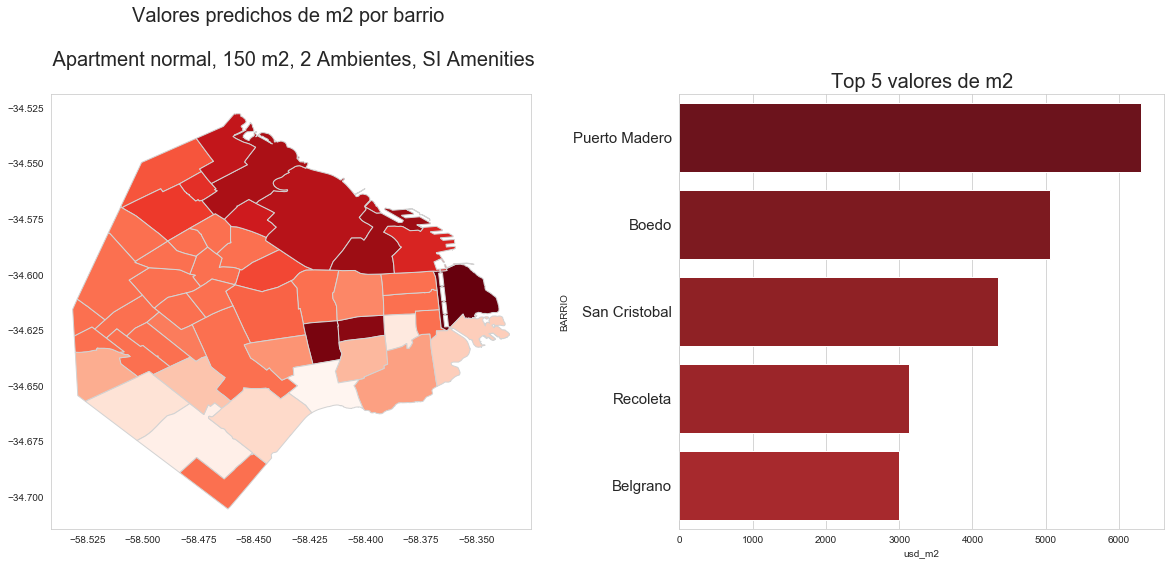

In [260]:
fig = plt.figure(figsize=(20,8))
#en 1 columna agrego 2 pares de ejes 
ax = fig.add_subplot(1,2,1)

custom_pal = sns.color_palette("Reds_r", 24)

resultados.plot(ax=ax,column='usd_m2',cmap='Reds',edgecolor='lightgrey')

plt.title('Valores predichos de m2 por barrio \n\n Apartment normal, 150 m2, 2 Ambientes, SI Amenities\n',size=20)
plt.grid(False)

ax1 = fig.add_subplot(1,2,2)
plt.title('Top 5 valores de m2',size=20)
plt.yticks(size=15)
barras = resultados.sort_values('usd_m2',ascending=False)
sns.barplot(x="usd_m2", y="BARRIO", data=barras.head(), ax=ax1,palette=custom_pal,dodge=False)

plt.subplots_adjust(hspace=0.5,wspace=0.3)

# lo cual coincide con nuestra API :D

In [261]:
loc_ = 'Puerto Madero' # se utiliza para establecer la mediana de lat-lon

prop_ = 'apartment'
size_ = 'normal'
superficie_m2 = 150
ambientes = 3
amenities = 1

datos_nuevos('Puerto Madero')

5787.17

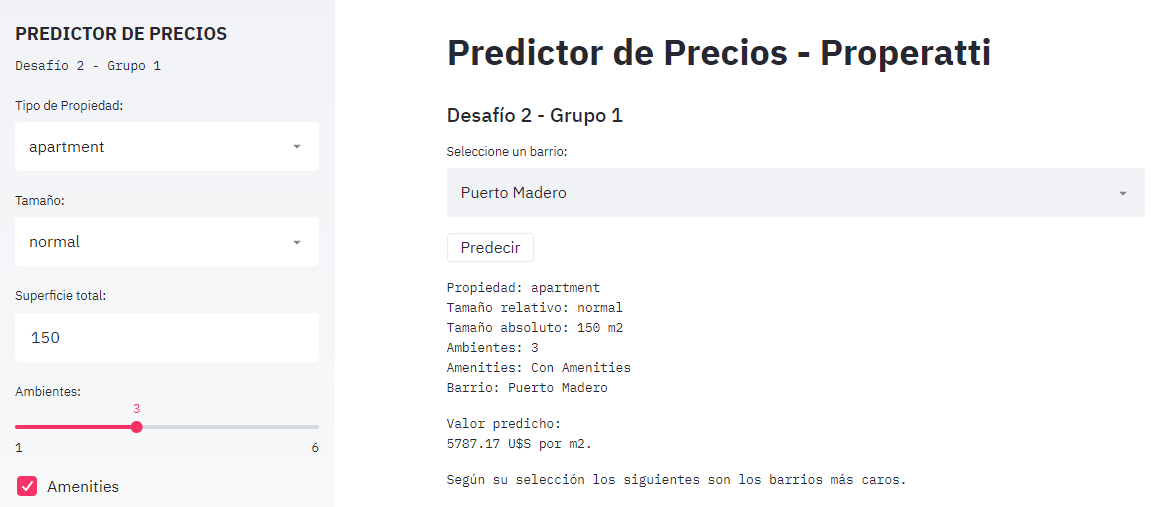

# FIN!!!

In [ ]:
tiempo()